In [3]:
class GIC: 
    def __init__(self,netpath,base,respath,date=None,qdate=None):
        """ Sets basic paths for location of files and sets dates

        Parameters
        ----------
        netpath : string (required) 
           location to folder where powernetwork csv files are
        base : string (required)
           general location to folder where data magnetic stations should be unpacked
        respath : string (required)
           location to folder where results need to be written
        date : string (optional)
           date of event for GIC calculation. Should be given as dd-mm-yyyy. Standard set as None type
        qdate : string (optional) 
           quiet magnetic day --> used to substract base magnetic value from active day (given by date). Should be given as dd-mm-yyyy. Standard set as None type

        Created Folders 
        ---------------
        "{self.base}/{self.date}" : folder where data magnetic station of active day is unpacked
        "{self.base}/{self.qdate}" : folder where data magnetic station of quiet day is unpacked
        
        Returns
        -------
        self.minute : boolean
           if True, data is recorded per minute; if False, data is recorded per second (set at False)
        self.samples : integer 
           nr of samples per day (set at zero)
        self.days : integer 
           number of days to be calculated (set at one)
        self.lentrafo : integer
           number of transformers in powernetwork csv file
        self.day : string 
           day number of event
        self.month : string
           month number of event
        self.year : string 
           year of event
        self.datevar : string 
           date returned as yyyy-mm-dd
        self.statpath : string
           exact location to folder where data magnetic station of active day is unpacked
        self.quietpath : string
           exact location to folder where data magnetic station of quiet day is unpacked
        self.netpath, self.base, self.respath, self.date, self.qdate (see Parameters) : all strings
        """
        import logging
        import os
        import pandas as pd
        self.netpath=netpath
        self.base=base
        self.respath=respath
        self.date=date
        self.qdate=qdate
        self.minute=None
        self.samples=0
        self.days=1
        self.lentrafo=len(pd.read_csv(self.netpath+'/spreadsheettrafo.csv', delimiter = ';')) 
        if not date == None:
            try:
                datesplit=self.date.split('-')
                self.day=str(datesplit[0]).zfill(2)
                self.month=str(datesplit[1]).zfill(2)
                self.year=str(datesplit[2])
                self.datevar=f'{self.year}-{self.month}-{self.day}' #get day string in reverse order, so yyyy-mm-dd
            except:
                logging.warning('Date has not been inputted correctly, it should be dd-mm-yyyy')
            try:
                self.statpath=f'{self.base}/{self.date}'
                os.mkdir(f'{self.base}/{self.date}')
            except:
                logging.warning(f"Directory '{self.statpath}' might already exist, or cannot be formed")
        else:
            self.day = self.month = self.year = self.datevar = self.statpath = None
            
        if not self.qdate==None:
            self.quietpath=f'{self.base}/{self.qdate}'
            try:
                os.mkdir(f'{self.base}/{self.qdate}')
            except:
                logging.warning(f"Directory '{self.quietpath}' might already exist, or cannot be formed")
        else:
            self.quietpath=None
        #create topomap for plotting GICs in correct colour, blue is into network, red is into ground
        f=open("topo.cpt","w+")
        f.write("-10000 0/0/100 0 0/0/100\n")
        f.write("0 100/0/0 10000 100/0/0")
        f.close()

    def BtoE(self,model,scaling=1):
        """ Transforms magnetic field values to electric field value using a given conductivity model. 
        Theory by Weaver's 'Mathematical methods for geo-electromagnetic induction' (1994) and Wait's 'Propagation of radio waves over a stratified ground' (1985)

        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        model : integer (required)
           determines which conductivity model is used to transform magnetic field observations to electric field
        scaling : float (optional)
           factor that is multiplied with magnetic field observations/interpolations to create extreme events. Standard set at one (no extra scaling).
        
        NEEDS MAGNETIC INTERPOLATED VALUES (.csv and .csv.Y) TO WORK!
 
        Functions
        ----------
        check_sampling() : obtain amount of samples, minute or second data, and amount of days from magnetic data
        filt(f,y) : applies a Wiener filter to remove high frequency noise
        Parzen(N) : creates a Parzen window for given length
        transferfunction(f,model) : gives factor to transform magnetic to electric field
        writing_electric(proc#,path,E,start,stop,lon,lat,localvar) : writes electric field into files per timestep
        
        Created Folders
        ---------------
        "{self.respath}/{self.date}/electric_field_north" : folder where electric field values in northern direction per timestep are stored
        "{self.respath}/{self.date}/electric_field_east" : folder where electric field values in eastern direction per timestep are stored

        Returns
        -------
        Electric_*.csv : csv file
           writes electric files per timestep into folder "{self.respath}/{self.date}/electric_field_north" and "{self.respath}/{self.date}/electric_field_east"
        """
        import numpy as np
        import os
        from multiprocessing import Process
        import pandas as pd
        from threading import local
        import logging
        localvar=local()

        # import magnetic field data in X/Y-direction (north)
        magnetic_Xfiles=[]
        magnetic_Yfiles=[]
        self.check_sampling()
        ############################# get the strings ###################################
        if self.minute==True:
            os.system(f"ls {self.respath}/{self.date}/interpolation/minute_????.csv > {self.respath}/{self.date}/tempX.txt")
            os.system(f"ls {self.respath}/{self.date}/interpolation/minute_????.csv.Y > {self.respath}/{self.date}/tempY.txt")
            f=open(f'{self.respath}/{self.date}/tempX.txt')
            for item in f:
                item=item.strip('\n')
                magnetic_Xfiles.append(item)
            f.close()
            os.system(f'rm {self.respath}/{self.date}/tempX.txt')
            f=open(f'{self.respath}/{self.date}/tempY.txt')
            for item in f:
                item=item.strip('\n')
                magnetic_Yfiles.append(item)
            f.close()
            os.system(f'rm {self.respath}/{self.date}/tempY.txt')
        else:
            for item in range(self.samples//10000+1):
                os.system(f"ls {self.respath}/{self.date}/interpolation/second_{item}????.csv >> {self.respath}/{self.date}/tempX.txt")
                os.system(f"ls {self.respath}/{self.date}/interpolation/second_{item}????.csv.Y >> {self.respath}/{self.date}/tempY.txt")
            f=open(f'{self.respath}/{self.date}/tempX.txt')
            for item in f:
                item=item.strip('\n')
                magnetic_Xfiles.append(item)
            f.close()
            os.system(f'rm {self.respath}/{self.date}/tempX.txt')
            f=open(f'{self.respath}/{self.date}/tempY.txt')
            for item in f:
                item=item.strip('\n')
                magnetic_Yfiles.append(item)
            f.close()
            os.system(f'rm {self.respath}/{self.date}/tempY.txt')

        magnetic_Xfiles=sorted(magnetic_Xfiles) #sort to number 0000-1440 or 86400
        magnetic_Yfiles=sorted(magnetic_Yfiles)
        
        for file in magnetic_Xfiles:
            Xfile=pd.read_csv(file, delimiter=' ', header=None)
            break
        for file in magnetic_Yfiles:
            Yfile=pd.read_csv(file, delimiter=' ', header=None)
            break

        lat=np.zeros(len(Xfile))
        lon=np.zeros(len(Xfile))
        MX_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))#matrix for storing values (vertical same place, horizontal same time)
        MX_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
        MXft_matrix=np.zeros((int(3*len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
        EX_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile)))
        EX_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
        EXft_matrix=np.zeros((int(3*len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
        MY_matrix=np.zeros((len(magnetic_Yfiles),len(Yfile))) #matrix for storing values (vertical same place, horizontal same time)
        MY_parz=np.zeros((3*len(magnetic_Yfiles),len(Yfile)))
        MYft_matrix=np.zeros((int(3*len(magnetic_Yfiles)/2)+1,len(Yfile)),dtype='complex')
        EY_matrix=np.zeros((len(magnetic_Xfiles),len(Xfile)))
        EY_parz=np.zeros((3*len(magnetic_Xfiles),len(Xfile)))
        EYft_matrix=np.zeros((int(3*len(magnetic_Xfiles)/2)+1,len(Xfile)),dtype='complex')
        ################################################################################# 
        ########################### get the values ######################################
        ######################### first x-direction #####################################
        print('setting up matrices!')
        for counter,file in enumerate(magnetic_Xfiles):
            Xfile=pd.read_csv(file, delimiter=' ', header=None)
            values=Xfile.to_numpy()
            if np.isnan(values).any():
                print(counter, np.argwhere(np.isnan(values)))
            MX_matrix[counter,:]=values[:,2]/(10**9)*scaling #scaling factor
        lat=values[:,1]
        lon=values[:,0]
        for counter,file in enumerate(magnetic_Yfiles):
            Yfile=pd.read_csv(file, delimiter=' ', header=None)
            values=Yfile.to_numpy()
            MY_matrix[counter,:]=values[:,2]/(10**9)*scaling
   
        ############## start fourier transformation ######################
        print('starting fourier transformation')

    # try Parzen window now
        MX_parz[0:len(magnetic_Xfiles),:]=MX_matrix[0,:]
        MX_parz[2*len(magnetic_Xfiles):,:]=MX_matrix[-1,:]
        MX_parz[len(magnetic_Xfiles):2*len(magnetic_Xfiles),:]=MX_matrix
        MY_parz[0:len(magnetic_Yfiles),:]=MY_matrix[0,:]
        MY_parz[2*len(magnetic_Yfiles):,:]=MY_matrix[-1,:]
        MY_parz[len(magnetic_Yfiles):2*len(magnetic_Yfiles),:]=MY_matrix
        for column in range(len(MX_matrix[0])):
            MXft_matrix[:,column]=np.fft.rfft(MX_parz[:,column]*self.Parzen(len(MX_parz))) #multiply with hanning window to reduce edge effects
        for column in range(len(MY_matrix[0])):
            MYft_matrix[:,column]=np.fft.rfft(MY_parz[:,column]*self.Parzen(len(MY_parz)))

        ######################### calculate Electric field in frequency direction #############################3
        # make frequencyvector in seconds
        df=1./(24*60*60.*self.days*3) # seconds! #aangepast
        if self.minute:
            fmax=1./(2*60.)
        else:
            fmax=1./(2*1)
        freqvec=np.arange(0,fmax+0.5*df,df)

        #filter signal for noise
        MXft_matrix=self.filt(freqvec,MXft_matrix)
        MYft_matrix=self.filt(freqvec,MYft_matrix)
        
        # t3_start=process_time() #1d conductivity model!
        for row in range(1,len(MXft_matrix)): #zero is not allowed, same row = same frequency
            EYft_matrix[row,:]=-1*MXft_matrix[row,:]*self.transferfunction(freqvec[row],model)
        for row in range(1,len(MYft_matrix)): #zero is not allowed
            EXft_matrix[row,:]=MYft_matrix[row,:]*self.transferfunction(freqvec[row],model)

        ######################## fourier transform back ####################################
        # t4_start=process_time()
        for column in range(len(EYft_matrix[0])):
            EY_parz[:,column]=np.fft.irfft(EYft_matrix[:,column])
        for column in range(len(EXft_matrix[0])):
            EX_parz[:,column]=np.fft.irfft(EXft_matrix[:,column])
            
        EX_matrix=EX_parz[len(magnetic_Xfiles):2*len(magnetic_Xfiles),:]
        EY_matrix=EY_parz[len(magnetic_Yfiles):2*len(magnetic_Yfiles),:]

        del MX_matrix, MX_parz, MXft_matrix, EX_parz, EXft_matrix, MY_matrix, MY_parz, MYft_matrix, EY_parz, EYft_matrix
        ######################### writing E field to files #################################
        # t5_start=process_time()
        try:
            os.mkdir(f'{self.respath}/{self.date}/electric_field_east')
        except:
            logging.warning('Directory is already created, data could be overwritten.')
        try:
            os.mkdir(f'{self.respath}/{self.date}/electric_field_north')
        except:
            logging.warning('Directory is already created, data could be overwritten.')

        n=6
        nrsteps=int(self.samples*self.days/n) #aangepast
        threads=list()
        for index in range(n):
            q=Process(target=self.writing_electric, args=(index+1, f'{self.respath}/{self.date}/electric_field_east', EY_matrix, nrsteps*index, nrsteps*(index+1), lon, lat, localvar))
            threads.append(q)
            q.start()
        for thread in threads:
            thread.join()

        threads=list()
        for index in range(n):
            q=Process(target=self.writing_electric, args=(index+1, f'{self.respath}/{self.date}/electric_field_north', EX_matrix, nrsteps*index, nrsteps*(index+1), lon, lat, localvar))
            threads.append(q)
            q.start()
        for thread in threads:
            thread.join()
        
    def calculate_GIC(self,guess=80, plotting=True):
        """ Calculates geomagnetically induced current in a given powergrid
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function.
        guess : integer (optional)
           gives an estimation in how many pieces the integration of the electric field should be executed in the calcE function. Standard set at 80.
        plotting : boolean (optional)
           if True, figures are generated containing the spatial variation of GICs in the given powergrid per timestep. Standard set at True

        NEEDS POWERGRID CSV FILES AND ELECTRIC FIELD TO WORK
        
        Functions
        ---------
        check_sampling() : obtain amount of samples, minute or second data, and amount of days from magnetic data
        GICfunction(proc#,start,stop,trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,trafo_cond,ground_cond,kabels,trafo_all_connections,guess,localvar,lock,plotting) : calculates the GICs in the network
        
        Created Folders
        ---------------
        "{self.respath}/{self.date}/GIC" : folder that contains results of GIC calculation
        
        Returns
        -------
        GIC_*.csv : csv file
           textfiles containing GICs at every transformer station per timestep.
        GIC_at_*.png : png file 
           if Plotting=True, images of spatial variation GICs in powergrid per timestep
        """
        import os
        import pandas as pd
        import numpy as np
        import logging
        from threading import local
        localvar=local()
        from multiprocessing import Process
        from multiprocessing import Lock
        lock=Lock()
        self.check_sampling()
        # create basic file: coordinates of trafo and cables
        netwerk=pd.read_csv(f'{self.netpath}/spreadsheetcables.csv', delimiter = ';')
        coord2=pd.DataFrame(columns=['lon', 'lat'])
        coord1=pd.DataFrame(columns=['lon', 'lat'])
        for line in range(len(netwerk)): # put end locations under start location for gmt, so that you double the lines
            coord1.at[2*line,'lon']=netwerk.at[line,'strtlon'] 
            coord1.at[2*line,'lat']=netwerk.at[line,'strtlat'] 
            coord1.at[2*line+1,'lon']=netwerk.at[line,'eindlon']
            coord1.at[2*line+1,'lat']=netwerk.at[line,'eindlat'] 
            # if statement to spot discontinuities
            if line>0 and coord1.at[2*line-1,'lat']!=coord1.at[2*line,'lat'] and coord1.at[2*line-1,'lon']!=coord1.at[2*line,'lon']:
                coord3=pd.DataFrame([[coord1.at[2*line,'lon'], coord1.at[2*line,'lat']]], columns=['lon', 'lat']) #create new dataframe
                coord1.at[2*line,'lon']='>'+str(coord1.at[2*line,'lon']) #add > for gmt
                coord2=coord2.append(coord1.loc[2*line]) #append it
                coord2=coord2.append(coord3) #append old one, otherwise no line will be drawn
                coord2=coord2.append(coord1.loc[2*line+1]) #append the one after
                del coord3
            else:
                coord2=coord2.append(coord1.loc[2*line])
                coord2=coord2.append(coord1.loc[2*line+1])

        #write to a file with no header and column titles
        coord2.to_csv(path_or_buf=f'{self.netpath}/cables.csv', sep=' ', index=False, header=False)
        
        #################################### first reading in datasets #####################################################  
        try:
            os.mkdir(f'{self.respath}/{self.date}/GIC')
        except:
            logging.warning(f"Directory '{self.respath}/{self.date}/GIC' has already been created, data could be destroyed!")
            print(f"Directory '{self.respath}/{self.date}/GIC' has already been created, data could be destroyed!")
        logging.info('Reading in datasets!')
        Electric_Xfiles=[]
        Electric_Yfiles=[]
        if self.minute:
            os.system(f' ls {self.respath}/{self.date}/electric_field_north/*.csv > {self.respath}/{self.date}/tempX.txt')
            os.system(f' ls {self.respath}/{self.date}/electric_field_east/*.csv > {self.respath}/{self.date}/tempY.txt')
        else:
            for item in range(self.samples//10000+1):
                os.system(f' ls {self.respath}/{self.date}/electric_field_north/electric_{item}????.csv >> {self.respath}/{self.date}/tempX.txt')
                os.system(f' ls {self.respath}/{self.date}/electric_field_east/electric_{item}????.csv >> {self.respath}/{self.date}/tempY.txt')
            
        f=open(f'{self.respath}/{self.date}/tempX.txt')
        for item in f:
            item=item.strip('\n')
            Electric_Xfiles.append(item)
        f.close()
        
        f=open(f'{self.respath}/{self.date}/tempY.txt')
        for item in f:
            item=item.strip('\n')
            Electric_Yfiles.append(item)
        f.close()
        os.system(f'rm {self.respath}/{self.date}/tempX.txt')
        os.system(f'rm {self.respath}/{self.date}/tempY.txt')
        logging.debug('Electric files created!')

        for counter,file in enumerate(Electric_Xfiles):
            Xfile=pd.read_csv(file, delimiter=' ', header=None)
            values=Xfile.to_numpy()
            break
        EX_matrix=np.zeros((len(Electric_Xfiles),len(values)))    
        EY_matrix=np.zeros((len(Electric_Xfiles),len(values)))
        logging.debug('Electric matrices have been made in memory!')

        for counter,file in enumerate(Electric_Xfiles):
            Xfile=pd.read_csv(file, delimiter=' ', header=None)
            values=Xfile.to_numpy()
            EX_matrix[counter,:]=values[:,2]
        logging.debug('EX_matrix has been made!')
        lat=values[:,1]
        lon=values[:,0]
        for counter,file in enumerate(Electric_Yfiles):
            Yfile=pd.read_csv(file, delimiter=' ', header=None)
            values=Yfile.to_numpy()
            EY_matrix[counter,:]=values[:,2]
        del item, f, Xfile, values, Yfile

        ######################################### Getting the needed GIC matrices and code #################################
        logging.info('Starting with the GIC code!')
        kabels=pd.read_csv(self.netpath+'/spreadsheetcables.csv', delimiter = ';')
        trafo=pd.read_csv(self.netpath+'/spreadsheettrafo.csv', delimiter = ';')
        trafo_connect=np.zeros((len(trafo),len(trafo))) #connectivity trafo
        trafo_all_connections=np.zeros((len(trafo),len(kabels))) #connections possible between trafo and every cable
        trafo_cond=np.zeros((len(trafo),len(trafo))) # The conductivity matrix
        station_lat=np.zeros(len(trafo)) #latitude stations in degrees
        station_lon=np.zeros(len(trafo)) #longitude stations in degrees
        ground_cond=np.zeros(len(trafo))
        cable_icon=np.zeros(len(kabels)) # icon array for cable and trafo resp.
        trafo_icon=np.zeros(len(trafo))

        ##### connect trafo and cable number to position in matrix #####
        for line in range(len(kabels)):
            cable_icon[line]=kabels.at[line,'kabelnr']
        for line in range(len(trafo)):
            trafo_icon[line]=trafo.at[line,'trafonr']
        ##### make trafo-trafo connectivity matrix ######
        for line in range(len(trafo)): 
            temp=str(trafo.at[line,'verbonden trafo']) #get right column
            temp=temp.split(",") #split values

            for item in temp:
                temp2=int(item)
                trafo_connect[line,np.where(trafo_icon == temp2)[0]]=True #check for connection other trafo
                del temp2
            del temp
        ###### make trafo-cable connectivity matrix ######
        for line in range(len(trafo)):
            temp=str(trafo.at[line,'alle aansluitingen'])
            temp=temp.split(",")
            for item in temp:
                temp2=int(item)
                trafo_all_connections[line,np.where(cable_icon == temp2)[0]]=True
                del temp2
            del temp
        ###### make conductivity matrix ######
        for row,line in enumerate(trafo_connect):
            trafo_cond[row,row]=trafo.at[row,'conductivity total']
            for column,item in enumerate(line):
                if item:
                    temp=trafo_all_connections[row,:]+trafo_all_connections[column,:]
                    temp2=0
                    for counter,value in enumerate(temp):
                        if value == 2: # if 2 then we have found the connecting cables
                            temp2+=1/(float(kabels.at[counter,'conductivity'])*kabels.at[counter,'kab/3'])  #because of serieschain we have to add 1/sigma

                    trafo_cond[row,column]=-1/temp2 #add cable resistance to off-diagonal
                    trafo_cond[row,row]+=1/temp2 #add cable resistance to trace
                    del temp, temp2

        ######### get necessary arrays ########
        for item in range(len(trafo)):
            station_lat[item]=trafo.at[item,'lat']
            station_lon[item]=trafo.at[item,'lon']
            ground_cond[item]=trafo.at[item,'conductivity total']
        ############################### Run the function with multiple processors ##########################################
        logging.info('Start multiprocessing!')
        print("New data is added now!")
        n=6
        nrsteps=int(self.samples*self.days/n)
        threads=list()
        for index in range(n):
            q=Process(target=self.GICfunction, args=(index+1,nrsteps*index,nrsteps*(index+1),trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,trafo_cond,ground_cond,kabels,trafo_all_connections,guess,localvar,lock,plotting))
            threads.append(q)
            q.start()
        for thread in threads:
            thread.join()
        logging.info("Script has been completed!")
        print("Script has been completed!")
        
    def calcE(self,kabels,EX_matrix,EY_matrix,lat,lon,time,guess,localvar): #E for all cables
        """ Integrates the electric field over the given cables to obtain potentials
        
        Parameters
        ----------
        kabels : pandas dataframe (required)
           contains information about the transmission cables, see spreadsheetcables.ods for clarification
        EX_matrix : numpy matrix (required)
           electric field in northern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        EY_matrix : numpy matrix (required)
           electric field in eastern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        lat : numpy array (required)
           latitude of spatial points where electric field is calculated
        lon : numpy array (required)
           longitude of spatial points where electric field is calculated
        time : integer (required)
           timestep for which the integration has to be carried out
        guess : integer (required)
           initial amount of integration intervals to calculate the electric potential
        localvar : object (required)
           object were every single processor can store its variables separately without mixing them up between processors
        
        NEEDS TO BE CALLED WITH GICfunction() TO WORK PROPERLY
           
        Returns
        -------
        localvar.E_all : numpy matrix
           electric potential (V/m) of every transmission cable
        """
        from scipy.interpolate import griddata
        from scipy.integrate import simps
        import numpy as np
        import logging
                         
        localvar.heading=np.zeros(len(kabels))
        localvar.old=np.zeros((len(kabels),2))
        nr=guess # amount of nodes
        while True:
            localvar.E_all=np.zeros((len(kabels),2))
            localvar.latrange=np.zeros((len(kabels),nr))
            localvar.lonrange=np.zeros((len(kabels),nr))
            localvar.GridEX=np.zeros((len(kabels),nr))
            localvar.GridEY=np.zeros((len(kabels),nr))
            for number in range(len(kabels)):
                localvar.latrange[number,:]=np.linspace(kabels.at[number,'strtlat'],kabels.at[number,'eindlat'],nr) 
                localvar.lonrange[number,:]=np.linspace(kabels.at[number,'strtlon'],kabels.at[number,'eindlon'],nr) 
                localvar.heading[number]=kabels.at[number,'heading']
            localvar.GridEX=griddata((lat,lon),EX_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic') #interpolate value
            localvar.GridEY=griddata((lat,lon),EY_matrix[time,:],(localvar.latrange,localvar.lonrange),method='cubic')
            for number in range(len(kabels)):
                localvar.E_all[number,0]+=abs(np.cos(np.radians(localvar.heading[number])))*simps(localvar.GridEX[number,:],np.linspace(0,kabels.at[number,'length'],nr))
                localvar.E_all[number,1]+=abs(np.sin(np.radians(localvar.heading[number])))*simps(localvar.GridEY[number,:],np.linspace(0,kabels.at[number,'length'],nr))
            if np.sum(abs(localvar.old-localvar.E_all))<10**-5: #only continue when difference in integration is lower than tolerance
                logging.info(f'{nr-(guess-1)} iterations were used for time={time}')
                break
            else:
                localvar.old[:,0]=localvar.E_all[:,0]
                localvar.old[:,1]=localvar.E_all[:,1]
                nr+=1
        return localvar.E_all
    
    def check_sampling(self):
        """ Checks magnetic data to get various 'self' objects, when functions are called separately.
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function

        NEEDS MAGNETIC INTERPOLATED DATA TO WORK
        
        Returns
        -------
        self.samples : integer
           amount of samples per day (either 1440 or 86400)
        self.days : integer
           amount of days for which GICs should be calculated
        self.minute : boolean
           if True, data is recorded per minute; if False, data is recorded per second        
        """
        import os
        self.samples=len([name for name in os.listdir(f'{self.respath}/{self.date}/interpolation') if os.path.isfile(os.path.join(f'{self.respath}/{self.date}/interpolation', name))])/2 #count amount of files in folder
        if self.samples%(24*60*60)==0:
            self.minute=False 
            self.days=int(self.samples/(24*60*60))
            self.samples=24*60*60
        elif self.samples%(24*60)==0:
            self.minute=True
            self.days=int(self.samples/(24*60))
            self.samples=24*60
        else:
            raise Exception("Data is missing, or it is no minute or second data")
        
    def download_data(self,day,month,year,station,types=True):
        """ Automatically downloads magnetic data from the Intermagnet ftp server
           ('ftp://ftp.seismo.nrcan.gc.ca/intermagnet')
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        day : string (required)
           daynumber of to be downloaded date
        month : string (required)
           monthnumber of to be downloaded date
        year : string (required)
           year of to be downloaded date
        station : string of length 3 (required)
           abbreviation of magnetic observatory in IAGA code
        types : boolean (optional)
           if True, minute data is to be downloaded (not available before 1991); if False, second data is to be downloaded (not available before 2011)
           
        Created Folders
        ---------------
        '{self.base}/{day}-{month}-{year}' : folder that will contain downloaded data
        
        Returns
        -------
        *dmin.min or *qsec.sec : text files
           header information and magnetic observations for one day
        """
        from urllib.request import urlretrieve
        import os
        import logging
        day=str(day).zfill(2)
        month=str(month).zfill(2)
        try:
            os.mkdir(f'{self.base}/{day}-{month}-{year}')
        except:
            logging.warning(f"Directory '{self.base}/{day}-{month}-{year}' might already exist, or cannot be formed")
        logging.info(f'Downloading data for station {station} on {day}-{month}-{year}')
        if types==True: #minute data
            URL="ftp://ftp.seismo.nrcan.gc.ca/intermagnet/minute/definitive/IAGA2002"
            try:
                urlretrieve(f'{URL}/{year}/{month}/{station}{year}{month}{day}dmin.min.gz', f'{self.base}/{day}-{month}-{year}/{station}{year}{month}{day}dmin.min.gz')
            except:
                raise Exception('Data does not exist for given input, station might not be recorded yet. Input should have length: 3-2-2-4')
            os.system(f'gunzip {self.base}/{day}-{month}-{year}/{station}{year}{month}{day}dmin.min.gz')
            os.system(f'rm {self.base}/{day}-{month}-{year}/{station}{year}{month}{day}dmin.min.gz')
            
        else: #second data
            URL="ftp://ftp.seismo.nrcan.gc.ca/intermagnet/second/quasi-definitive/IAGA2002"
            try:
                urlretrieve(f'{URL}/{year}/{month}/{station}{year}{month}{day}qsec.sec.gz', f'{self.base}/{day}-{month}-{year}/{station}{year}{month}{day}qsec.sec.gz')
            except:
                raise Exception('Data does not exist for given input, station might not be recorded yet. Input should have length: 3-2-2-4')
            os.system(f'gunzip {self.base}/{day}-{month}-{year}/{station}{year}{month}{day}qsec.sec.gz') 
            os.system(f'rm {self.base}/{day}-{month}-{year}/{station}{year}{month}{day}qsec.sec.gz') 

    def filt(self,x,ft_matrix): 
        """ Applies Wiener filter to given data to remove noise
        
        Parameters
        ----------
        x : numpy array (required)
           contains frequency components from zero to larger
        ft_matrix : numpy matrix (required)
           contains Fourier transformed data (frequency domain) in a (fstep,pnts) matrix. fstep is amount of frequency steps, pnts is the amount of spatial points. 
        
        Functions
        ---------
        func(x,a,b) : creates exponential function of type b*10^(a*x)
        
        Returns
        -------
        signal : numpy matrix
           (fstep,pnts) matrix containing Wiener filtered data
        """
        from scipy.optimize import curve_fit
        import numpy as np
        signal=np.zeros((len(ft_matrix),len(ft_matrix[0])), dtype='complex')
        n=len(x)
        
        PSD=2*np.nansum(abs(ft_matrix), axis=1)/len(ft_matrix) #create mean power spectrum density
        a,sigma=curve_fit(self.func, x[2*int(n/3):], 2*np.nansum(abs(ft_matrix[2*int(n/3):]), axis=1)/len(ft_matrix)) #fit a exp line to end graph
        Wiener=(PSD-self.func(x,*a))/PSD #create filter
        for i in range(len(ft_matrix[0])):
            signal[:,i]=ft_matrix[:,i]*Wiener #apply filter
        return signal
            
    def find_quiet_date(self):
        """ Find solar quiet day nearest to inputted assumed solar active day using the ftp server of Potzdam
           ('ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/quietdst')
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        
        NEED DATE OF ACTIVE DAY TO WORK
        
        Returns
        -------
        Quiet.day : string
           daynumber of nearest solar quiet day
        Quiet.month : string
           monthnumber of nearest solar quiet day
        Quiet.year : string
            year of nearest solar quiet day
        """
        from urllib.request import urlretrieve
        import os
        import logging
        import datetime
        URL='ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/quietdst'
        monthlist=[0,2,3,4,5,6,7,9,10,11,12,13,14]
        try: #retrieve data from the Potzdam website
            urlretrieve(f'{URL}/qd{self.year[0:3]}0{self.year[2]}9.txt', f'{self.base}/Kp_index_{self.year}.txt')
        except:
            try:
                urlretrieve(f'{URL}/qd{self.year[0:3]}0{self.year[2]}x.txt', f'{self.base}/Kp_index_{self.year}.txt')
            except:
                raise Exception('URL could not be retrieved, check your date string!')
        # find correct files on potzdam website and extract quiet days of the month for variety of situations
        if self.month=='12' and self.year[3]=='9':
            newyear=str(int(self.year)+1)
            try:
                urlretrieve(f'{URL}/qd{newyear[0:3]}0{newyear[2]}9.txt', f'{self.base}/Kp_index_{newyear}.txt')
            except:
                try:
                    urlretrieve(f'{URL}/qd{newyear[0:3]}0{newyear[2]}x.txt', f'{self.base}/Kp_index_{newyear}.txt')
                except:
                    raise Exception('URL could not be retrieved, check your date string!')
            f=open(f'{self.base}/Kp_index_{self.year}.txt')
            for counter,line in enumerate(f):
                if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)-1]+2:
                    words=line.split()
                    option0=[''.join(i for i in words[2] if i.isdigit()), int(self.month)-1, self.year]
                    option0A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)-1, self.year]

                if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)]+2:
                    words=line.split()
                    option1=[''.join(i for i in words[2] if i.isdigit()), self.month, self.year]
                    option1A=[''.join(i for i in words[3] if i.isdigit()), self.month, self.year]
                    f.close()
                    os.system(f'rm {self.base}/Kp_index_{self.year}.txt')
                    break
            f=open(f'{self.base}/Kp_index_{newyear}.txt')
            for counter,line in enumerate(f):
                if counter==4:
                    words=line.split()
                    option2=[''.join(i for i in words[2] if i.isdigit()), 1, int(self.year)+1]
                    option2A=[''.join(i for i in words[3] if i.isdigit()), 1, int(self.year)+1]
                    f.close()
                    os.system(f'rm {self.base}/Kp_index_{newyear}.txt')
                    break
            
        elif self.month=='01' and self.year[3]=='0':
            newyear=str(int(self.year)-1)
            try:
                urlretrieve(f'{URL}/qd{newyear[0:3]}0{newyear[2]}9.txt', f'{self.base}/Kp_index_{newyear}.txt')
            except:
                try:
                    urlretrieve(f'{URL}/qd{newyear[0:3]}0{newyear[2]}x.txt', f'{self.base}/Kp_index_{newyear}.txt')
                except:
                    raise Exception('URL could not be retrieved, check your date string!')
            f=open(f'{self.base}/Kp_index_{newyear}.txt')
            for counter,line in enumerate(f):
                if counter==130:
                    words=line.split()
                    option0=[''.join(i for i in words[2] if i.isdigit()), 12, int(self.year)-1]
                    option0A=[''.join(i for i in words[3] if i.isdigit()), 12, int(self.year)-1]
                    f.close()
                    os.system(f'rm {self.base}/Kp_index_{newyear}.txt')
                    break
            f=open(f'{self.base}/Kp_index_{self.year}.txt')
            for counter,line in enumerate(f):
                if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)]+2:
                    words=line.split()
                    option1=[''.join(i for i in words[2] if i.isdigit()), self.month, self.year]
                    option1A=[''.join(i for i in words[3] if i.isdigit()), self.month, self.year]

                if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)+1]+2:
                    words=line.split()
                    option2=[''.join(i for i in words[2] if i.isdigit()), int(self.month)+1, self.year]
                    option2A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)+1, self.year]
                    f.close()
                    os.system(f'rm {self.base}/Kp_index_{self.year}.txt')
                    break
        
        else:
            f=open(f'{self.base}/Kp_index_{self.year}.txt')
            for counter,line in enumerate(f):
                if self.month=='12':
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)-1]+2:
                        words=line.split()
                        option0=[''.join(i for i in words[2] if i.isdigit()), int(self.month)-1, self.year]
                        option0A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)-1, self.year]
                
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)]+2:
                        words=line.split()
                        option1=[''.join(i for i in words[2] if i.isdigit()), self.month, self.year]
                        option1A=[''.join(i for i in words[3] if i.isdigit()), self.month, self.year]
                        
                    if counter==(int(self.year)-int(self.year[0:3])*10+1)*14+4:
                        words=line.split()
                        option2=[''.join(i for i in words[2] if i.isdigit()), 1, int(self.year)+1]
                        option2A=[''.join(i for i in words[3] if i.isdigit()), 1, int(self.year)+1]
                        f.close()
                        os.system(f'rm {self.base}/Kp_index_{self.year}.txt')
                        break
                elif self.month=='1':
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+2:
                        words=line.split()
                        option0=[''.join(i for i in words[2] if i.isdigit()), 12, int(self.year)-1]
                        option0A=[''.join(i for i in words[3] if i.isdigit()), 12, int(self.year)-1]
                
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)]+2:
                        words=line.split()
                        option1=[''.join(i for i in words[2] if i.isdigit()), self.month, self.year]
                        option1A=[''.join(i for i in words[3] if i.isdigit()), self.month, self.year]
                        
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)+1]+2:
                        words=line.split()
                        option2=[''.join(i for i in words[2] if i.isdigit()), int(self.month)+1, self.year]
                        option2A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)+1, self.year]
                        f.close()
                        os.system(f'rm {self.base}/Kp_index_{self.year}.txt')
                        break
                else:
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)-1]+2:
                        words=line.split()
                        option0=[''.join(i for i in words[2] if i.isdigit()), int(self.month)-1, self.year]
                        option0A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)-1, self.year]
                
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)]+2:
                        words=line.split()
                        option1=[''.join(i for i in words[2] if i.isdigit()), self.month, self.year]
                        option1A=[''.join(i for i in words[3] if i.isdigit()), self.month, self.year]
                        
                    if counter==(int(self.year)-int(self.year[0:3])*10)*14+monthlist[int(self.month)+1]+2:
                        words=line.split()
                        option2=[''.join(i for i in words[2] if i.isdigit()), int(self.month)+1, self.year]
                        option2A=[''.join(i for i in words[3] if i.isdigit()), int(self.month)+1, self.year]
                        f.close()
                        os.system(f'rm {self.base}/Kp_index_{self.year}.txt')
                        break
                        
        #which option is closest to disturbed day?
        logging.info(f"optional quiet days are (previous/this/next month): {option0} OR {option0A} / {option1} OR {option1A} / {option2} OR {option2A}")
        datestring=[datetime.datetime(int(option0[2]),int(option0[1]),int(option0[0])),datetime.datetime(int(option1[2]),int(option1[1]),int(option1[0])),datetime.datetime(int(option2[2]),int(option2[1]),int(option2[0])),datetime.datetime(int(option0A[2]),int(option0A[1]),int(option0A[0])),datetime.datetime(int(option1A[2]),int(option1A[1]),int(option1A[0])),datetime.datetime(int(option2A[2]),int(option2A[1]),int(option2A[0]))]
        Quiet=min(datestring, key=lambda x: abs(x - datetime.datetime(int(self.year),int(self.month),int(self.day))))
        return Quiet.day, Quiet.month, Quiet.year
        
    def func(self,x,a,b):
        """ Calculates a exponential function
        
        Parameters
        ----------
        x : float (required)
           variable
        a : float (required)
           constant
        b : float (required)
           constant
        
        Returns
        -------
        b*10 ** (a*x) : float
            exponential function
        """
        return b*10 ** (a*x)
    
    def GICfunction(self,q,begin,end,trafo,EX_matrix,EY_matrix,lat,lon,station_lat,station_lon,trafo_connect,trafo_cond,
                    ground_cond,kabels,trafo_all_connections,guess,localvar,lock,plotting):
        """ Calculate and plot the GICs in the powergrid
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        q : integer (required)
           processor number
        begin : integer (required)
           starting timestep of calculation
        end : integer (required)
           ending timestep of calculation
        trafo : pandas dataframe (required)
           dataframe containing information about the transformers, see spreadsheettrafo.ods for clarification
        EX_matrix : numpy matrix (required)
           electric field in northern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        EY_matrix : numpy matrix (required)
           electric field in eastern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        lat : numpy array (required)
           latitude of spatial points where electric field is calculated
        lon : numpy array (required)
           longitude of spatial points where electric field is calculated
        station_lat : float (required)
           latitude of tranformer station
        station_lon : float (required)
           longitude of tranformer station
        trafo_connect : boolean numpy matrix (required)
           symmetric matrix (len(trafo),len(trafo)) that determines whether tranformers are directly connected to each other (=True) or not (=False)
        trafo_cond : numpy matrix (required)
           conductivity matrix as defined by Boteler & Pirjola's 'Modeling geomagnetically induced currents' (2017)
        ground_cond : numpy array (required)
           conductivity of transformer to ground
        kabels : pandas dataframe (required)
           contains information about the transmission cables, see spreadsheetcables.ods for clarification
        trafo_all_connections : boolean numpy array (required)
           matrix (size: amount of transformers x amount of cables) that determines which cables are connected to a transformer (=True) or not (=False)
        guess : integer (required)
           initial amount of integration intervals to calculate the electric potential
        localvar : object (required)
           object were every single processor can store its variables separately without mixing them up between processors
        lock : object (required)
           locks a piece of code for other processors when one processor is working on it
        plotting : boolean (required)
           if True, GIC_at_*.png files are created

        NEEDS TO BE CALLED WITH calculate_GIC() TO WORK PROPERLY 

        Functions
        ---------
        ObtainJ(proc#,kabels,EX_matrix,EY_matrix,lat,lon,localvar.time,trafo_connect,trafo_all_connections,trafo_cond,trafo,guess,localvar) : calculates induced currents in transmission cables
        
        Returns
        -------
        GIC_*.csv : csv file
           textfiles containing GICs at every transformer station per timestep.
        GIC_at_*.png : png file 
           if Plotting=True, images of spatial variation GICs in powergrid per timestep
        """
        import numpy as np
        import pandas as pd
        import os
        import logging
    ######################################### interpolation ############################################################
        localvar.volt_result=np.zeros(len(trafo))
        localvar.J_total=np.zeros(len(trafo))
        logging.info(f'Thread {q} has started interpolation!')
        for localvar.time in range(begin,end):#range(len(grid_EX)):
            localvar.J_north, localvar.J_east=self.ObtainJ(q,kabels,EX_matrix,EY_matrix,lat,lon,localvar.time,trafo_connect,trafo_all_connections,trafo_cond,trafo,guess,localvar)
            localvar.J_total=localvar.J_north+localvar.J_east
            localvar.volt_result=np.linalg.solve(trafo_cond,localvar.J_total)
            localvar.I_GIC=localvar.volt_result*ground_cond
            if np.isnan(min(localvar.I_GIC)):
                raise ValueError("OOPS, your current is NaN!")
    ##################################### getting max I_GIC and writing results ########################################
            logging.info(f'Thread {q} is writing results to files for timestep {localvar.time}!')
            localvar.maxAMP=1 #1
            if self.minute:
                localvar.tijd=str(localvar.time).zfill(4)
            else:
                localvar.tijd=str(localvar.time).zfill(5)
            ##### Save files #######
            localvar.GIC=pd.DataFrame(columns=['lon','lat','GIC',f'GIC/{localvar.maxAMP}'])
            localvar.GIC.at[:,'lon']=station_lon
            localvar.GIC.at[:,'lat']=station_lat
            localvar.GIC.at[:,'GIC']=localvar.I_GIC
            localvar.GIC.at[:,f'GIC/{localvar.maxAMP}']=localvar.I_GIC/localvar.maxAMP
            localvar.GIC.to_csv(path_or_buf=f'{self.respath}/{self.date}/GIC/GIC_{localvar.tijd}.csv', sep=';', index=False, header=True)
            logging.info(f'Thread {q} has written, now plotting GIC!')
    ################################### Plotting results ###############################################################
            if plotting==True:
                lim1=3.3
                lim2=7.5
                lim3=50.5
                lim4=54
                legendlon=lim1+0.18
                legendlat=lim4-0.1
                textlon=legendlon+0.40 #0.33
                textlat=legendlat-0.01

                with lock:
                    legend=open(f'{self.netpath}/legend.txt','w+')
                    legend.write(f'{legendlon} {legendlat} 1 1')
                    legend.close()
                    legendtxt=open(f'{self.netpath}/legendtext.txt', 'w+')
                    legendtxt.write(f'{textlon} {textlat} {localvar.maxAMP}A')
                    legendtxt.close()

                    ##### Use GMT to plot GICs ######
                    if self.minute:
                        minute=str(localvar.time%60).zfill(2)
                        hour=str(int(localvar.time/60)%24).zfill(2)
                        DAY=int(localvar.time/(60*24))
                        title=f'GIC at {self.date} - {DAY}:{hour}:{minute}'
                        proj='-JM15C -P'
                        lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
                        psfile=f'{self.respath}/{self.date}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
                        pngfile=f'{self.respath}/{self.date}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
                        os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
                        os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
                        os.system(f'gmt psxy {self.netpath}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
                        os.system(f'gmt psxy {self.respath}/{self.date}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
                        os.system(f'gmt psxy {self.netpath}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
                        os.system(f'gmt pstext {self.netpath}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
                    else:
                        second=str(localvar.time%60).zfill(2)
                        minute=str(int(localvar.time/60)%60).zfill(2)
                        hour=str(int(localvar.time/(60*60))%24).zfill(2)
                        DAY=int(localvar.time/(60*60*24))
                        title=f'GIC at {self.date} - {DAY}:{hour}:{minute}:{second}'
                        proj='-JM15C -P'
                        lims=f'-R{lim1}/{lim2}/{lim3}/{lim4}'
                        psfile=f'{self.respath}/{self.date}/GIC/GIC_at_{localvar.tijd}.ps' #aanpassen
                        pngfile=f'{self.respath}/{self.date}/GIC/GIC_at_{localvar.tijd}.png' #aanpassen
                        os.system(f'gmt pscoast {proj} {lims} -W0.5p -K -Ggrey -Slightblue -Df -N1/0.25p> {psfile}' )
                        os.system(f'gmt psbasemap {proj} {lims} -Ba1g1 -BWeSn+t"{title}" -O -K>> {psfile}' )
                        os.system(f'gmt psxy {self.netpath}/cables.csv {proj} {lims} -W0.5p -Wred -O -K>> {psfile}' )
                        os.system(f'gmt psxy {self.respath}/{self.date}/GIC/GIC_{localvar.tijd}.csv {proj} {lims} -Ctopo.cpt -Scc -O -K>> {psfile}')    
                        os.system(f'gmt psxy {self.netpath}/legend.txt {proj} {lims} -Ctopo.cpt -W -Scc -O -K>> {psfile}')
                        os.system(f'gmt pstext {self.netpath}/legendtext.txt {proj} {lims} -F+f30pHelvetica,black -O>> {psfile}')
                os.system(f'convert -density 300 {psfile} {pngfile}')
                os.system(f'rm {psfile}')

            logging.info(f'Thread {q} has fulfilled timestep {localvar.time}!')
        logging.info(f'Thread {q} is finished!')
    
    def GIC_index(self,samples,days,minute,overwrite=False):
        """ Calculates the GIC index for all given magnetic station observatories according to 
        Marshall et al.'s 'A preliminary risk assessment of the Australian region power network to space weather' (2011)

        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        overwrite : boolean (optional)
           if True, old maximum GIC values are overwritten
           
        NEEDS MAGNETIC OBSERVATIONS TO WORK
         
        Functions
        ---------
        check_sampling() : obtain amount of samples, minute or second data, and amount of days from magnetic data
        Parzen(N) : creates a Parzen window for given length
        
        Returns
        -------
        GIC_index.txt : text file
           textfile containing the maximum GIC index per magnetic observatory, in following order : lon, lat, GICx-index, GICy-index
        GICx_index.png/GICy_index.png : png file
           graph of GIC index in both northern and eastern direction
        """
        import os
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        self.days=int(days)
        self.samples=int(samples)
        self.minute=bool(minute)
        if overwrite:
            g=open(f'{self.respath}/{self.date}/GIC_index.txt','w+')
        else:
            g=open(f'{self.respath}/{self.date}/GIC_index.txt','a+')
        maxx=0
        maxy=0
        Xcomp=np.zeros(self.samples*self.days)
        XParz=np.zeros(self.samples*3*self.days)
        GICxft=np.zeros((int(self.samples/2*3*self.days)+1), dtype='complex')
        GICx=np.zeros(self.samples*3*self.days)
        Ycomp=np.zeros(self.samples*self.days)
        YParz=np.zeros(self.samples*3*self.days)
        GICyft=np.zeros((int(self.samples/2*3*self.days)+1), dtype='complex')
        GICy=np.zeros(self.samples*3*self.days)
        df=1/(60*60*24*3.*self.days) # *3 for Parzen window
        if self.minute:
            fmax=1/(2*60.)
        else:
            fmax=1/(2*1)
        freqvector=np.arange(0,fmax+df,df) #create frequency vector
        timevector=np.linspace(0,24*self.days,self.samples*self.days)

        figx=plt.figure(figsize=(15,10)) #initialize plotting GICx
        axx=figx.add_subplot()
        axx.set_title('GICx index')
        axx.set_ylabel('GICx')
        axx.set_xlabel('Time (h)')
        axx.axhline(16, linestyle='--', color='green')#, label='5%')
        axx.axhline(43, linestyle='--', color='yellow')#, label='35%')
        axx.axhline(114, linestyle='--', color='orange')#, label='65%')
        axx.axhline(304, linestyle='--', color='red')#, label='95%')
        figy=plt.figure(figsize=(15,10)) #initialize plotting GICy
        axy=figy.add_subplot()
        axy.set_title('GICy index')
        axy.set_ylabel('GICy')
        axy.set_xlabel('Time (h)')
        axy.axhline(39, linestyle='--', color='green')#, label='5%')
        axy.axhline(97, linestyle='--', color='yellow')#, label='35%')
        axy.axhline(241, linestyle='--', color='orange')#, label='65%')
        axy.axhline(600, linestyle='--', color='red')#, label='95%')
#         axx.legend(loc='upper right')
#         axy.legend(loc='upper right')
        
        os.system(f'ls -d {self.respath}/{self.date}/*/ > {self.respath}/{self.date}/temp.txt') #get location
        f=open(f'{self.respath}/{self.date}/temp.txt')
        string=[]
        for item in f:
            item=item.strip("\n")
            string.append(item)
        string=sorted(string)
        f.close()
        os.system(f'rm {self.respath}/{self.date}/temp.txt')
        temp_var=self.statpath
        self.statpath='/usr/people/out/Documents/Magnetic_field/magnetic_data/Tozzi/23-10-2003_Tozzi/'
        os.system(f'ls {self.statpath} > {self.respath}/{self.date}/temp.txt') #get coordinates
        f=open(f'{self.respath}/{self.date}/temp.txt')
        string2=[]
        for item in f:
            item=item.strip("\n")
            string2.append(item)
        string2=sorted(string2)
        lat=np.zeros(len(string2))
        lon=np.zeros(len(string2))
        stat=[]
        for counter2,item in enumerate(string2):
            File=open(f'{self.statpath}/{item}')
            for counter,line in enumerate(File):
                if counter==2:
                    words=line.split()
                    stat.append(words[2])
                if counter==4:
                    words=line.split()
                    lat[counter2]=float(words[2]) # latitude station
                if counter==5:
                    words=line.split()
                    lon[counter2]=float(words[2]) # longitude station
                    break
        f.close()
        self.statpath=temp_var
        os.system(f'rm {self.respath}/{self.date}/temp.txt')
        for counter3,station in enumerate(string):
            if self.days==1:
                newfile=pd.read_csv(f'{station}/allresults.csv', delimiter=';')
            else:
                newfile=pd.read_csv(f'{station}/merged_allresults.csv', delimiter=';')
            Xcomp=newfile['B_theta (nt)'].to_numpy()
            Ycomp=newfile['B_phi (nt)'].to_numpy()
            XParz[:self.samples*self.days]=Xcomp[0] #make Parzen vector
            XParz[self.samples*self.days:self.samples*2*self.days]=Xcomp
            XParz[self.samples*2*self.days:]=Xcomp[-1]
            YParz[:self.samples*self.days]=Ycomp[0]
            YParz[self.samples*self.days:self.samples*2*self.days]=Ycomp
            YParz[self.samples*2*self.days:]=Ycomp[-1]
            Xft=np.fft.rfft(XParz*self.Parzen(self.samples*3*self.days)) #fourier transform into frequency domain
            Yft=np.fft.rfft(YParz*self.Parzen(self.samples*3*self.days))

            for counter,freq in enumerate(freqvector):
                GICxft[counter]=Yft[counter]*np.exp(1j*np.pi/4.)*np.sqrt(freq/fmax)
                GICyft[counter]=Xft[counter]*np.exp(1j*np.pi/4.)*np.sqrt(freq/fmax)
            GICx=np.fft.irfft(GICxft)
            GICy=np.fft.irfft(GICyft)

            g.write(f"{lon[counter3]} {lat[counter3]} {max(GICx[self.samples*self.days:self.samples*2*self.days])} {max(GICy[self.samples*self.days:self.samples*2*self.days])} {stat[counter3]}\n")
            axx.plot(timevector,GICx[self.samples*self.days:self.samples*2*self.days],label=f'{stat[counter3]}')
            axy.plot(timevector,GICy[self.samples*self.days:self.samples*2*self.days],label=f'{stat[counter3]}')
            if max(GICx)>maxx:
                maxx=max(GICx)
            if max(GICy)>maxy:
                maxy=max(GICy)
                
        g.close()
        axx.legend()
        axy.legend()
        axx.set_ylim(0,maxx+10)
        axy.set_ylim(0,maxy+10)
        figx.savefig(f'{self.respath}/{self.date}/GICx_index.png')
        figy.savefig(f'{self.respath}/{self.date}/GICy_index.png')
        
    def glue_data(self,paths,foldername):
        """ Put data of mutiple consequental days together
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        paths : array of strings (required)
           paths, IN RIGHT ORDER, of the magnetic interpolated data of the consequental days
        foldername : string (required)
           name of the folder where these combined magnetic interpolations need to go
        """
        import os #BE SURE TO PLACE THEM (Magnetic interpolation) IN CORRECT ORDER! SO E.G.: [29-10-2003, 30-10-2003, 31-10-2003]
        import logging
        logging.warning(f'Look Out! self.date is now changed from {self.date} to {foldername}!')
        self.date=foldername
        for path in paths:
            if self.samples==0:
                self.samples=len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])/2 #both x and y files
                if self.samples==24*60:
                    self.minute=True
                elif self.samples==24*60*60:
                    self.minute=False
                else:
                    raise Exception("Folders do not contain minute or second data, or data is missing!")
            elif self.samples!=0 and self.samples!=int(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])/2):
                raise Exception("Folders contain different amount of files!")
            else:
                pass
        test=str(int(self.samples*len(paths)))
        fill=len(test) #get length of number string
        try:
            os.mkdir(f'{self.respath}/{foldername}')
        except:
            logging.warning(f'Directory "{self.respath}/{foldername}" is already created, data could be lost forever!')
        try:
            os.mkdir(f'{self.respath}/{foldername}/interpolation')
        except:
            logging.warning(f'Directory "{self.respath}/{foldername}/interpolation" is already created, data could be lost forever!')
        #give files new numbering
        if self.minute:
            for counter,item in enumerate(paths):
                for nr in range(int(self.samples)):
                    os.system(f'cp {item}/minute_{str(nr).zfill(4)}.csv {self.respath}/{foldername}/interpolation/minute_{str(int(nr+counter*self.samples)).zfill(fill)}.csv')
                    os.system(f'cp {item}/minute_{str(nr).zfill(4)}.csv.Y {self.respath}/{foldername}/interpolation/minute_{str(int(nr+counter*self.samples)).zfill(fill)}.csv.Y')
        else:
            for counter,item in enumerate(paths):
                for nr in range(int(self.samples)):
                    os.system(f'cp {item}/second_{str(nr).zfill(5)}.csv {self.respath}/{foldername}/interpolation/second_{str(int(nr+counter*self.samples)).zfill(fill)}.csv')
                    os.system(f'cp {item}/second_{str(nr).zfill(5)}.csv.Y {self.respath}/{foldername}/interpolation/second_{str(int(nr+counter*self.samples)).zfill(fill)}.csv.Y')
        logging.info('Data copying is finished!')
                    
    def glue_video(self,nameout,gluefile=None,videos=None):
        """ Combine multiple mp4-videos together
        
        Parameters
        ----------
        nameout : string (required)
           name of the new mp4-video file
        gluefile : string (only if videos=None, required; else optional)
           file containing the location of the videos to be merged, starting with `file'
        videos : array of strings (only if gluefile=None, required; else optional)
           array containing the location of the different videos in consequental order
           
        Returns
        -------
        *.mp4 : mp4-video file
           merged video
        """
        import os
        if gluefile==None:
            f=open('gluefile.txt', 'w+')
            for item in videos:
                f.write(f"file '{item}' \n")
            f.close()
            os.system(f'ffmpeg -f concat -safe 0 -i gluefile.txt -c copy {self.respath}/{nameout}.mp4')
            os.system('rm gluefile.txt')
        else:
            os.system(f'ffmpeg -f concat -safe 0 -i {gluefile} -c copy {self.respath}/{nameout}.mp4')
        # gluefile should have lines like: file '/usr/people/out/Documents/Magnetic_field/station_results/31-10-2003/GIC.mp4'
        
    def iteratestation(self,figures=False,plots=True):
        """ Iterate the function newplotspace for multiple magnetic observatories
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        figures : boolean (optional)
           if True, figures are opened in the terminal
        plots : boolean (optional)
           if True, plots of mangetic signal are generated and placed in a folder
        
        NEEDS RAW DATA MAGNETIC OBSERVATORIES TO WORK
        
        Functions
        ---------
        newplotspace(stringactive,stringquiet,figures,plots) : function that extract magnetic data and returns reduced magnetic signal by subtracting quiet day from active day
        """
        import os
        string=os.listdir(self.statpath)
        string=sorted(string)
        stringquiet=os.listdir(self.quietpath)
        stringquiet=sorted(stringquiet)
        if len(string)!=len(stringquiet):
            raise Exception(f'Quiet and active days should have the same stations, now there are {len(stringquiet)} quiet stations and {len(string)} active stations!')
        for counter,item in enumerate(string):
            self.newplotspace(string[counter],stringquiet[counter],figures=False,plots=True)
     
    def magnetic_interpolation(self):
        """ Interpolates magnetic field for given domain
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
           
        NEEDS PROCESSED DATA MAGNETIC OBSERAVTORIES TO WORK
        NR OF PROCESSORS IS SET AT 3, DUE TO COMPUTATIONAL LIMITS. NR CAN BE INCREASED AT OWN RISK
        
        Functions
        ---------
        magnetic_time(proc#,start,stop,location,string,localvar) : function that interpolates and write interpolated magnetic values to files per timestep
        
        Returns
        -------
        *csv and *csv.Y : csv files
           interpolated magnetic signal over northwest Europe
        """
        import logging
        import os
        import numpy as np
        import threading
        from multiprocessing import Process
        localvar=threading.local()
        RE=6371000
        
        string=(file for file in os.listdir(self.statpath) if os.path.isfile(os.path.join(self.statpath, file)))
        string=sorted(string) #sort alphabetically, otherwise problems later
        logging.debug(f'Used stations are: {string} \n')
        location=np.zeros((len(string),3))
        location[:,2]=RE
        for counter1,item in enumerate(string):
            File=open(f'{self.statpath}/{item}','r')
            for counter2,line in enumerate(File):
                words=line.split()
                if counter2==4:
                    word=line.split()
                    location[counter1,0]=word[2] #latitude
                if counter2==5:
                    word=line.split()
                    location[counter1,1]=word[2] #longitude           
                if words[0]=='DATE':
                    datastart=counter2
                    
            File.close()
            self.samples=counter2-datastart
            if self.samples == 24*60:
                self.minute = True
            elif self.samples == 24*60*60:
                self.minute = False
            else:
                raise ValueError(f"Amount of samples ({self.samples}) does not correspond to minute or second data!")
        string=[]
        os.system(f' ls -d {self.respath}/{self.date}/*{self.datevar} > {self.respath}/{self.date}/temp.txt') 
        f=open(f'{self.respath}/{self.date}/temp.txt')
        for item in f:
            item=item.strip('\n')
            string.append(item)
        string=sorted(string) #sort alphabetically, otherwise problems now
        f.close()
        os.system(f'rm {self.respath}/{self.date}/temp.txt')
        print(string)
        
        try:
            os.mkdir(f'{self.respath}/{self.date}/interpolation')
        except:
            print('Directory is already created, data could be overwritten.')
            logging.info('Directory is already created, data could be overwritten.')

        n=3 #no more than 3 processors at a time for 16GB memory
        nrsteps=int(self.samples/n)
        threads=list()
        for index in range(n):
            q=Process(target=self.magnetic_time, args=(index+1, nrsteps*index, nrsteps*(index+1),location,string,localvar))
            threads.append(q)
            q.start()
        for thread in threads:
            thread.join()
        
    def magnetic_time(self,q,stepmin,stepmax,location,string,localvar):
        """ Calculated interpolated values and write them to files
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        q : integer (required)
           processor number
        stepmin : integer (required)
           starting timestep
        stepmax : integer (required)
           ending timestep
        location : numpy matrix (required)
           (#stations,3) matrix containing latitude, longitude, and radius (of the Earth) per station
        string : array of string (required)
          path to folders of magnetic observatories
        localvar : object (required)
           object were every single processor can store its variables separately without mixing them up between processors
        
        NEEDS TO BE USED WITH FUNCTION magnetic_interpolation() TO WORK PROPERLY
        
        Functions
        ---------
        mag_interpolate(location,localvar.values,np.array([43,63,-13,20]),0.5) : function that carries out the actual interpolation per timestep
        
        Returns
        -------
        *csv and *csv.Y : csv files
           interpolated magnetic signal over northwest Europe        
        """
        import pandas as pd
        import numpy as np
        import logging
        
        logging.info(f'Thread {q} is running, starting at {stepmin}.')
        for counter3 in range(stepmin,stepmax): #minutes per day
            localvar.values=np.zeros((len(string),3))
            logging.info(f'Thread {q} got a lock')
            for localvar.counter1,localvar.item in enumerate(string):
                localvar.File=open(f'{localvar.item}/allresults.csv')
                for localvar.counter2,localvar.line in enumerate(localvar.File):
                    if localvar.counter2==(counter3+1):
                        localvar.word=localvar.line.split(';')
                        localvar.values[localvar.counter1,:]=[localvar.word[0],localvar.word[1],localvar.word[2]]
                        break
                localvar.File.close()

            localvar.result=self.mag_interpolate(location,localvar.values,np.array([52,71,14,31]),0.5)
            if np.isnan(localvar.result).any():
                print(counter3, np.argwhere(np.isnan(localvar.result)))
            logging.info(f'Thread {q} released lock and finished interpolating for step {counter3}.')
            
            localvar.newfile1=pd.DataFrame(columns=['lon','lat','Bx'])
            localvar.newfile2=pd.DataFrame(columns=['lon','lat','By'])

            logging.info(f'Thread {q} is busy writing to file.')
            localvar.newfile1['lon']=localvar.result[:,1]
            localvar.newfile1['lat']=localvar.result[:,0]
            localvar.newfile1['Bx']=localvar.result[:,2]
            localvar.newfile2['lon']=localvar.result[:,1]
            localvar.newfile2['lat']=localvar.result[:,0]
            localvar.newfile2['By']=localvar.result[:,3]
 
            logging.info(f'Thread {q} is searching.')
            if self.minute==True:
                localvar.newfile1.to_csv(path_or_buf=f'{self.respath}/{self.date}/interpolation/minute_{str(counter3).zfill(4)}.csv', sep=' ', index=False, header=False)
                localvar.newfile2.to_csv(path_or_buf=f'{self.respath}/{self.date}/interpolation/minute_{str(counter3).zfill(4)}.csv.Y', sep=' ', index=False, header=False)
            else:
                localvar.newfile1.to_csv(path_or_buf=f'{self.respath}/{self.date}/interpolation/minute_{str(counter3).zfill(5)}.csv', sep=' ', index=False, header=False)
                localvar.newfile2.to_csv(path_or_buf=f'{self.respath}/{self.date}/interpolation/minute_{str(counter3).zfill(5)}.csv.Y', sep=' ', index=False, header=False)
        
            logging.info(f'Thread {q} has found.')
        logging.warning(f'Thread {q} has finished.')
            
    def mag_interpolate(self,loc,val,latlon,delta):
        """ Interpolates magnetic data over northwestern European domain
        
        Parameters
        ----------
        loc : numpy matrix (required)
           (#stations,3) matrix containing latitude, longitude, and radius (of the Earth) per station
        val : numpy matrix (required)
           (#stations,3) matrix containing radial, latitudonal, and longitudonal component of the magnetic field at a station for a specific timestep
        latlon : numpy array (required)
           area over which we want to interpolate the magnetic data, given as [minimum_latitude, maximum_latitude, minimum_longitude, maximum_longitude]
        delta : float (required)
           spacing of the area over which we want to interpolate; here 0.5 is a safe guess
        
        NEEDS TO BE USED WITH magnetic_time() TO WORK PROPERLY
        
        Functions
        ---------
        USES THE SPECIAL PACKAGE pySECS (class SECS); INSTALL BEFOREHAND!
        SECS(location_of_poles) : initialise class
        SECS.fit(loc,val) : scale poles to observed values (val) at given locations (loc) (upscaling)
        SECS.predict(prediction_location, False) : project the scaled poles back to the whole domain (downscaling)
        
        Returns
        -------
        result : numpy array
           (points in domain, 4) matrix contains latitude, longitude, interpolated northern component, interpolated eastern component for every point in the given domain per timestep
        """
        import numpy as np
        from pySECS import SECS 
        
        if loc.shape[-1] != 3:
            raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
        if val.shape[-1] != 3:
            raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
        if latlon.shape[-1] != 4:
            raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
        RE=6371e3

        latlon[1]+=delta
        latlon[3]+=delta

        lats = np.arange(latlon[0], latlon[1], delta)
        lons = np.arange(latlon[2], latlon[3], delta)

        nlat = len(lats)
        nlon = len(lons)

        xx, yy = np.meshgrid(lons, lats) #make nice mesh

        sec_loc=np.zeros((nlat*nlon,3))
        #add poles to sec_loc
        sec_loc[:,0]=yy.ravel()
        sec_loc[:,1]=xx.ravel()
        sec_loc[:,2]=RE+110e3 #system is 110 km above ground with multiple poles

        system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)

        system_df.fit(loc,val) #fit currents to values

    ################## The prediction/interpolation begins ################
        
#         predlats = np.arange(50.7, 56.3, 0.07) #England
#         predlons = np.arange(-4.9, 0.6, 0.07)

#         predlats = np.arange(59.5, 68, 0.1) #Finland
#         predlons = np.arange(18, 32, 0.1)

#         nrpoint=len(predlats)*len(predlons)

#         predxx, predyy = np.meshgrid(predlons, predlats) #make nice mesh
        
        
        predlats = np.arange(48.85, 54.4, 0.05) #Netherlands+Belgium&Germany
        predlons = np.arange(3.2, 10.1, 0.05)
        predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
        predlonseng = np.arange(0.7, 3.29, 0.05)
        predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
        predlonsnor = np.arange(6.1, 6.94, 0.05)

        nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)
        pred_loc=np.zeros((nrpoint,3))
        predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
        predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
        predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
        predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
        predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))
#         nrpoint=1
#         predxx=4.599 #Dourbes
#         predyy=50.100
#         pred_loc=np.zeros((nrpoint,3))
        #add locations
        pred_loc[:,0]=predyy.ravel()
        pred_loc[:,1]=predxx.ravel()
        pred_loc[:,2]=RE #system is at ground
        prediction=system_df.predict(pred_loc, False)
        result=np.zeros((nrpoint,4))
        result[:,0]=predyy.ravel()
        result[:,1]=predxx.ravel()
        result[:,2]=prediction[:,0]
        result[:,3]=prediction[:,1]
        return result

    def make_video(self,namein,nameout):
        """ Creates mp4-video from png files
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        namein : string (required)
           location + name of png file, without its timestamp number
        nameout : string (required)
           name of the created mp4-video
           
        Returns
        -------
        *.mp4 : mp4-video at '{self.respath}/{self.date}'
        """
        import os
        os.system(f'ffmpeg -framerate 24 -pattern_type glob -i "{namein}*.png" {self.respath}/{self.date}/{nameout}.mp4')
    
    def newplotspace(self,activeday,quietday,figures=False,plots=True):
        """ Converts raw data to input data for interpolation by substracting quiet solar day from active day
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        activeday : string (required)
           folder which contains the magnetic observations from the active solar day
        quietday : string (required)
           folder which contains the magnetic observations from the quiet solar day
        figures : boolean (optional)
           if True, figures are plot in the terminal
        plots : boolean (optional)
           if True, figures are created and placed in the appropriate station folder in '{self.respath}/{self.date}'
        
        Created Folders
        ---------------
        '{self.respath}/{self.date}' : folder where all processed stations will be stored
        '{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}' : folder where all data of one station is stored
        
        Returns
        -------
        allresults.csv : csv file
           storage of processed magnetic data per station; every row correponds to one timestep
           file contains per column: B_theta, B_phi, B_r, B_H, dB_theta/dt, dB_phi/dt, dBH/dt
        *.png : png file
           various graphic overviews of the allresults.csv file
        """
        #import needed packages
        import os
        import numpy as np
        import pandas as pd
        import matplotlib
        %matplotlib inline
        import matplotlib.pyplot as plt
        import re
        possible_characters = ('-', ' ')
    ##### calculate values from observation station #####
        # read-in file of station
        File=open(f'{self.quietpath}/{quietday}','r') # open file
        HorX=[] # make some lists
        DeclY=[]
        VertZ=[]
        X2=[]
        for counter,line in enumerate(File):
            words=line.split()
            if words[0]=='DATE':
                datastart=counter+2
                for counter2,letters in enumerate(words[3]):
                    if counter2==3:
                        if letters=='H':
                            types=False
                            break
                        if letters=='X':
                            types=True
                            break
        File=open(f'{self.quietpath}/{quietday}','r')
        counter=0
        for counter,line in enumerate(File):
            if counter==2:
                words=line.split()
                station=words[2]
                
            if counter>=datastart-1: #read when the data starts
                words=line.split()
                if counter==datastart:
                    for newcounter,letters in enumerate(words[1]):
                        if newcounter==4:
                            if letters=='1' and self.samples==0:
                                self.minute=True
                                self.samples=24*60
                            if letters=='0' and self.samples==0:
                                self.minute=False
                                self.samples=24*60*60
                            if letters=='1' and self.samples!=0 and self.minute==False:
                                raise Exception('Data is not of the same type (min and s)!')
                            if letters=='0' and self.samples!=0 and self.minute==True:
                                raise Exception('Data is not of the same type (min and s)!')

                
                if float(words[3])>90000: #then no data is saved, but previous sample or zero is stored
                    if counter==datastart-1:
                        HorX.append(0)
                    else:
                        HorX.append(HorX[-1]) # get horizontal or X-component
                else:
                    HorX.append(float(words[3]))

                if float(words[4])>90000:
                    if counter==datastart-1:
                        DeclY.append(0)
                    else:
                        DeclY.append(DeclY[-1]) # get 'declination' or Y-component
                else:
                    DeclY.append(float(words[4]))

                if float(words[5])>90000:
                    if counter==datastart-1:
                        VertZ.append(0)
                    else:
                        VertZ.append(VertZ[-1]) # get vertical component or Z-component
                else:
                    VertZ.append(float(words[5]))
            
        File.close()

        if types: #if given in XYZ, types==true
            X2=HorX
            Y2=DeclY
            Z2=VertZ

        else: #if given in HDZ, types==false
            for item in range(len(DeclY)):
                X2.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
            Y2=DeclY
            Z2=VertZ

        File=open(f'{self.statpath}/{activeday}','r') # open file
        HorX=[] # make some lists
        DeclY=[]
        VertZ=[]
        X1=[]
        N=0
        for counter,line in enumerate(File):
            words=line.split()
            if words[0]=='DATE':
                datastart=counter+2
                for counter2,letters in enumerate(words[3]):
                    if counter2==3:
                        if letters=='H':
                            types=False
                            break
                        if letters=='X':
                            types=True
                            break
        File=open(f'{self.statpath}/{activeday}','r')
        counter=0
        for counter,line in enumerate(File):
            if counter==2:
                words=line.split()
                station=words[2]
            if counter>=datastart-1: #read when the data starts
                N+=1
                if counter==datastart-1:
                    dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date

                words=line.split()
                if float(words[3])>90000: #then no data is saved, but previous sample or zero is stored
                    if counter==datastart-1:
                        HorX.append(0)
                    else:
                        HorX.append(HorX[-1]) # get horizontal or X-component
                else:
                    HorX.append(float(words[3]))

                if float(words[4])>90000:
                    if counter==datastart-1:
                        DeclY.append(0)
                    else:
                        DeclY.append(DeclY[-1]) # get 'declination' or Y-component
                else:
                    DeclY.append(float(words[4]))

                if float(words[5])>90000:
                    if counter==datastart-1:
                        VertZ.append(0)
                    else:
                        VertZ.append(VertZ[-1]) # get vertical component or Z-component
                else:
                    VertZ.append(float(words[5]))

        File.close()
        try:
            os.mkdir(f'{self.respath}/{self.date}')
        except Exception:
            pass
        try:
            os.mkdir(f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
        except Exception:
            pass

        if types: #if given in XYZ, types==true
            X1=HorX
            Y1=DeclY
            Z1=VertZ

        else: #if given in HDZ, types==false
            for item in range(len(DeclY)):
                X1.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
            Y1=DeclY
            Z1=VertZ
    ##### calculate model value of magnetic field #####
        # set up
        time = np.linspace(0,24,N)


    ##### subtract the two data sets! #####
        SpaceX=np.subtract(X1,X2)
        SpaceY=np.subtract(Y1,Y2)
        SpaceZ=np.subtract(Z1,Z2)

    ##### plot data #####
        if figures:
            figx=plt.figure(figsize=(20,10))
            ax1=figx.add_subplot(311)
            ax11=figx.add_subplot(312)
            ax12=figx.add_subplot(313)
            ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax12.set_xlabel('time (days after 1 jan 2000)')
            ax11.set_ylabel('$B_\\theta$ (nt)')
            ax11.plot(time,X1,label='observed',color='blue')
            ax12.plot(time,X2,label='model',color='green')
            ax1.plot(time,SpaceX,label='residue',color='red')
            ax1.legend()
            ax11.legend()
            ax12.legend()

            figy=plt.figure(figsize=(20,10))
            ax2=figy.add_subplot(311)
            ax21=figy.add_subplot(312)
            ax22=figy.add_subplot(313)
            ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax22.set_xlabel('time (days after 1 jan 2000)')
            ax21.set_ylabel('$B_\\phi$ (nt)')
            ax21.plot(time,Y1,label='total',color='blue')
            ax22.plot(time,Y2,label='model',color='green')
            ax2.plot(time,SpaceY,label='residue',color='red')
            ax2.legend()
            ax21.legend()
            ax22.legend()

            figz=plt.figure(figsize=(20,10))
            ax3=figz.add_subplot(311)
            ax31=figz.add_subplot(312)
            ax32=figz.add_subplot(313)
            ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
            ax32.set_xlabel('time (days after 1 jan 2000)')
            ax31.set_ylabel('$B_r$ (nt)')
            ax31.plot(time,Z1,label='total',color='blue')
            ax32.plot(time,Z2,label='model',color='green')
            ax3.plot(time,SpaceZ,label='residue',color='red')
            ax3.legend()
            ax31.legend()
            ax32.legend()
            plt.show()

        if plots:
            figall=plt.figure(figsize=(20,10))
            ax4=figall.add_subplot(311)
            ax41=figall.add_subplot(312)
            ax42=figall.add_subplot(313)
            ax4.set_title('Radial component')
            ax41.set_title('Longitudinal component')
            ax41.set_ylabel('nanoteslas')
            ax42.set_title('Latitudional component')
            ax4.plot(time,SpaceZ,color='red')
            ax41.plot(time,SpaceY,color='red')
            ax42.plot(time,SpaceX,color='red')
            plt.savefig(f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')

    ##### calculate frequency spectrum #####
        # try to get time derivative, only horizontal components matter
        dXdt=np.zeros(len(SpaceX)) # define length array
        dYdt=np.zeros(len(SpaceY))

        for item in range(len(SpaceX)-1): # obtain derivative
            dXdt[item]=SpaceX[item+1]-SpaceX[item]
            dYdt[item]=SpaceY[item+1]-SpaceY[item]

        if plots:
            figx=plt.figure()
            ax1=figx.add_subplot()
            ax1.set_title('d$B_X$/dt at ' + station)
            ax1.set_xlabel('time (days after 1 jan 2000)')
            if self.minute:
                ax1.set_ylabel(f'd$B_X$/dt (nt/min)')
            else:
                ax1.set_ylabel(f'd$B_X$/dt (nt/s)')
            ax1.plot(time,dXdt,label='residue',color='red')
            ax1.legend()
            plt.savefig(f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

            figy=plt.figure()
            ax2=figy.add_subplot()
            ax2.set_title('d$B_Y$/dt at ' + station)
            ax2.set_xlabel('time (days after 1 jan 2000)')
            if self.minute:
                ax1.set_ylabel(f'd$B_Y$/dt (nt/min)')
            else:
                ax1.set_ylabel(f'd$B_Y$/dt (nt/s)')
            ax2.plot(time,dYdt,label='residue',color='red')
            ax2.legend()

            plt.savefig(f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')

        ### horizontal component ###
        Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
        dHdt=np.zeros(len(Hor_comp))
        for item in range(len(Hor_comp)-1): # obtain derivative
            dHdt[item]=Hor_comp[item+1]-Hor_comp[item]

        figH=plt.figure()
        ax1=figH.add_subplot(211)
        ax1.set_title('horizontal component at ' + station)
        ax1.set_xlabel('time')
        ax1.set_ylabel('nT')
        ax1.plot(time,Hor_comp,color='red')
        ax2=figH.add_subplot(212)
        ax2.set_xlabel('time')
        if self.minute:
            ax2.set_ylabel('nT/min')
        else:
            ax2.set_ylabel('nT/s')
        ax2.plot(time,dHdt,color='red')
        plt.savefig(f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')

    # ##### save files #####
        newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
        newfile['B_theta (nt)']=SpaceX
        newfile['B_phi (nt)']=SpaceY
        newfile['B_r (nt)']=SpaceZ
        newfile['B_H']=Hor_comp
        newfile['dBx/dt']=dXdt
        newfile['dBy/dt']=dYdt
        newfile['dBH/dt']=dHdt
        newfile.to_csv(path_or_buf=f'{self.respath}/{self.date}/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)
        plt.close('all')

    def ObtainJ(self,q,kabels,EX_matrix,EY_matrix,lat,lon,time,trafo_connect,trafo_all_connections,trafo_cond,trafo,guess,localvar):
        """ Calculates the induced current in the cables and 'sums' them together per transformerstation
        
        Parameters
        ----------
        q : integer (required)
           processor number
        kabels : pandas dataframe (required)
           contains information about the transmission cables, see spreadsheetcables.ods for clarification
        EX_matrix : numpy matrix (required)
           electric field in northern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        EY_matrix : numpy matrix (required)
           electric field in eastern direction stored in a (tsteps,npts) matrix. tsteps are the amount of timesteps, npts are the number of spatial points for which the electric field is calculated
        lat : numpy array (required)
           latitude of spatial points where electric field is calculated
        lon : numpy array (required)
           longitude of spatial points where electric field is calculated
        time : integer (required)
           timestep for which the integration has to be carried out
        trafo_connect : boolean numpy matrix (required)
           symmetric matrix (len(trafo),len(trafo)) that determines whether tranformers are directly connected to each other (=True) or not (=False)
        trafo_cond : numpy matrix (required)
           conductivity matrix as defined by Boteler & Pirjola's 'Modeling geomagnetically induced currents' (2017)
        trafo : pandas dataframe (required)
           dataframe containing information about the transformers, see spreadsheettrafo.ods for clarification
        guess : integer (required)
           initial amount of integration intervals to calculate the electric potential
        localvar : object (required)
           object were every single processor can store its variables separately without mixing them up between processors
        
        NEEDS TO BE USED WITH GICfunction() TO WORK PROPERLY
        
        Functions
        ---------
        calcE(kabels,EX_matrix,EY_matrix,lat,lon,time,guess,localvar) : calculates the electric potential per transmission cable
        
        Returns
        -------
        localvar.J_north : numpy array
           contains the sum of all northern directed induced currents per transformer station
        localvar.J_east :  numpy array
           contains the sum of all eastern directed induced currents per transformer station
        """
        import numpy as np
        import logging
        
        localvar.cablecheck=np.zeros(len(kabels))
        localvar.E_kabels=np.zeros((len(kabels),2))      
        logging.info(f'Thread {q} has started integration procedure!')
        localvar.E_kabels=self.calcE(kabels,EX_matrix,EY_matrix,lat,lon,time,guess,localvar)
        logging.info(f'Thread {q} has finished integration procedure and is now writing results!')
        localvar.stat_voltN=np.zeros((len(trafo_connect),len(trafo_connect)))
        localvar.stat_voltE=np.zeros((len(trafo_connect),len(trafo_connect)))
        localvar.J_north=np.zeros(len(trafo_connect))
        localvar.J_east=np.zeros(len(trafo_connect))
        for localvar.row,localvar.line in enumerate(trafo_connect):
            ruleA=999
            for localvar.column,localvar.item in enumerate(localvar.line):
                if localvar.item:
                    for localvar.number in range(len(kabels)):
                        localvar.cablecheck[localvar.number]=trafo_all_connections[localvar.row,localvar.number]+trafo_all_connections[localvar.column,localvar.number]
                    localvar.A=np.array(np.where(localvar.cablecheck==2)) #find indices that indicate cables connected

                    localvar.coord=trafo.at[localvar.row,'lat']
                    for localvar.counter2 in range(len(localvar.A[0])): #double loop to check the cable connections
                        for localvar.counter in range(len(localvar.A[0])):
                            if abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'strtlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51: #check coord for which cable is connected and same cable is not allowed!
                                localvar.coord=kabels.at[localvar.A[0,localvar.counter],'eindlat']
                                ruleA=localvar.A[0,localvar.counter] #rule to ensure that the same cable is not picked again

                                # first North component
                                if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                    localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                                else:
                                    localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                                # now East component    
                                if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                    localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                                else:
                                    localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                                break                           
                            elif abs(localvar.coord-kabels.at[localvar.A[0,localvar.counter],'eindlat'])<0.00001 and abs(ruleA-localvar.A[0,localvar.counter])>0.51:
                                ruleA=localvar.A[0,localvar.counter]
                                localvar.coord=kabels.at[localvar.A[0,localvar.counter],'strtlat']

                                # first North component
                                if kabels.at[localvar.A[0,localvar.counter],'strtlat'] < kabels.at[localvar.A[0,localvar.counter],'eindlat']:
                                    localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]
                                else:
                                    localvar.stat_voltN[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],0]*-1
                                # now East component    
                                if kabels.at[localvar.A[0,localvar.counter],'strtlon'] < kabels.at[localvar.A[0,localvar.counter],'eindlon']:
                                    localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]
                                else:
                                    localvar.stat_voltE[localvar.row,localvar.column]+=localvar.E_kabels[localvar.A[0,localvar.counter],1]*-1
                                break
                            else:
                                pass

                localvar.J_north[localvar.row]+=localvar.stat_voltN[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1 #extra -1 -1 to get J in opposite direction of E
                localvar.J_east[localvar.row]+=localvar.stat_voltE[localvar.row,localvar.column]*trafo_cond[localvar.row,localvar.column]*-1*-1
        return localvar.J_north, localvar.J_east
    
    def Parzen(self,N):
        """ Creates a Parzen window/filter for inputted length
        
        Parameters
        ----------
        N : integer (required)
           sets length of Parzen window
           
        Returns
        -------
        W : numpy array
           the Parzen filter to be applied to the data with length N
        """
        import numpy as np
        W=np.zeros(N)
        for nr in range(N):
            W[nr]=1-(2*(nr-N/2)/N)**8
        return W
    
    def plottinglatlon(self,q,string,string2,start,end,lock,lock2):
        """ Optional plotting of the magnetic interpolated values over Dutch powergrid
        
        Parameters
        ----------
        q : integer (required)
           processor number
        string : list of strings (required)
           list to location of northward directed mangetic values
        string2 : list of strings (required)
           list to location of eastward directed mangetic values
        start : integer (required)
           starting timestep 
        end : integer (required)
           ending timestep
        lock : object (required)
           locks a piece of code for other processors when one processor is working on it
        lock2 : object (required)
           locks a piece of code for other processors when one processor is working on it
        
        NEEDS TO BE USED WITH plot_magnetic() TO WORK PROPERLY
        
        Returns
        -------
        minlat_*.png : png files
           visual representation of magnetic contourlines over the Dutch (and surrounding) area
        """
        import logging
        import os
        proj='-JM15C -P'
        lims1='-R18/30/59.5/70'#'-R-4.9/0.6/50.7/56.3'
        lims2='-R18/30/59.5/70'#'-R-4.9/0.6/50.7/56.3'
        for item in string[start:end]:
            with lock:
                item2=item.strip('.csv')
                nr=item2.strip('minute_')
                logging.info(f'Thread {q} has obtained latlock for step {nr}.')
                time1=[int(int(nr)/60),int(nr)%60]
                time1[0]=str(time1[0]).zfill(2)
                time1[1]=str(time1[1]).zfill(2)

                os.system(f'gmt xyz2grd {self.respath}/{self.date}/interpolation/{item} -G{self.respath}/{self.date}/Graphs/gridlat{nr}.grd -I0.1 -V -N0 {lims1}')
                psfile1=f'{self.respath}/{self.date}/Graphs/minlat_{nr}.ps'
                os.system(f'gmt pscoast {proj} {lims2} -W0.25p -Ggrey -Slightblue -N1/0.25p -Df -K> {psfile1}' )
                os.system(f'gmt psbasemap {proj} {lims2} -Ba1 -BWeSn+t"Bx at {self.date} -- {time1[0]}:{time1[1]}" -O -K>> {psfile1}' )
                os.system(f'gmt grdcontour {self.respath}/{self.date}/Graphs/gridlat{nr}.grd -C10 -A50+f9p {proj} {lims2} -O >>{psfile1}')
                logging.info(f'Thread {q} has released latlock.')
#             os.system(f'convert -density 300 {psfile1} {self.respath}/{self.date}/Graphs/minlat_{nr}.png')
#             os.system(f'rm {psfile1}')
            os.system(f'rm {self.respath}/{self.date}/Graphs/gridlat{nr}.grd')
            logging.info(f'Thread {q} has finished plotting lat for step {nr}.')  

        for item in string2[start:end]:
            with lock2:
                item2=item.strip('.csv.Y')
                nr=item2.strip('minute_')
                logging.info(f'Thread {q} has obtained lonlock for step {nr}.')
                time2=[int(int(nr)/60),int(nr)%60]
                time2[0]=str(time2[0]).zfill(2)
                time2[1]=str(time2[1]).zfill(2)

                os.system(f'gmt xyz2grd {self.respath}/{self.date}/interpolation/{item} -G{self.respath}/{self.date}/Graphs/gridlon{nr}.grd -I0.1 -V -N0 {lims1}')
                psfile2=f'{self.respath}/{self.date}/Graphs/minlon_{nr}.ps'
                os.system(f'gmt pscoast {proj} {lims2} -W0.25p -Ggrey -Slightblue -N1/0.25p -Df -K> {psfile2}' )
                os.system(f'gmt psbasemap {proj} {lims2} -Ba1 -BWeSn+t"By at {self.date} -- {time2[0]}:{time2[1]}" -O -K>> {psfile2}' )
                os.system(f'gmt grdcontour {self.respath}/{self.date}/Graphs/gridlon{nr}.grd -C10 -A50+f9p {proj} {lims2} -O >>{psfile2}')
                logging.info(f'Thread {q} has released lonlock.')
#             os.system(f'convert -density 300 {psfile2} {self.respath}/{self.date}/Graphs/minlon_{nr}.png')
#             os.system(f'rm {psfile2}')
            os.system(f'rm {self.respath}/{self.date}/Graphs/gridlon{nr}.grd')
            logging.info(f'Thread {q} has finished plotting lon for step {nr}.')
        
    def plot_GIC(self,stationlist=[None,None]):
        """ Gives a visual representation of GIC per transformer over time
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        stationlist : list of integers (optional)
           this list of numbers represents the transformer stations we want to use for our visualisation
        
        NEEDS GIC_*.csv FILES TO FUNCTION. GIC_*.csv FILES ARE OBTAINED IN calculate_GIC()
        
        Functions
        ---------
        check_sampling() : obtain amount of samples, minute or second data, and amount of days from magnetic data
        
        Returns
        -------
        GIC_allstations.png : png file
           a visual representation of GIC per transformer over time
        """
        # plot timelapse GIC
        import matplotlib.pyplot as plt
        import os
        import numpy as np
        import pandas as pd
        self.check_sampling()
        if all(elements is None for elements in stationlist):
            # Dutch stations to plot
            A=np.arange(3,21)
            B=np.arange(46,54,1)
            stationlist=np.hstack([0,1,A,28,29,32,33,35,43,44,B])
           
        #reading in all GIC files
        if self.minute:
            os.system(f"ls {self.respath}/{self.date}/GIC/GIC_*.csv > {self.respath}/{self.date}/temp.txt")
        else:
            for item in range(self.samples//10000+1):
                os.system(f"ls {self.respath}/{self.date}/GIC/GIC_{item}*.csv >> {self.respath}/{self.date}/temp.txt")
        f=open(f"{self.respath}/{self.date}/temp.txt")
        string=[]

        GIC_data=np.zeros((self.samples*self.days,self.lentrafo))

        for item in f:
            item=item.rstrip('\n')
            string.append(item)
        string=sorted(string)
        for counter,time in enumerate(string):
            GIC_file=pd.read_csv(time, delimiter=';')
            GIC=GIC_file.to_numpy()
            GIC_data[counter]=GIC[:,2]

        os.system(f'rm {self.respath}/{self.date}/temp.txt')

        stationframe=pd.read_csv(f'{self.netpath}/spreadsheettrafo.csv', delimiter=';')
        # plot it, per station
        plt.rcParams.update({'font.size': 14}) 
        timevector=np.linspace(0,24*self.days,self.samples*self.days)
        fig1=plt.figure(figsize=(20,15))
        ax1=fig1.add_subplot()
        ax1.set_title(f'GIC during {self.date}')
        ax1.set_ylabel('GIC (A)')
        ax1.set_xlabel('Time (hours)')
#         plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Accent(np.linspace(0, 0.9, len(stationlist)))))
        for station in stationlist:
            ax1.plot(timevector,GIC_data[:,station],label=stationframe.at[station,'naam'])
        # plt.subplots_adjust(left=0)
        ax1.grid()
        ax1.set_xlim(0,71)
        lgd=ax1.legend(bbox_to_anchor=(1.01,1))
        plt.savefig(f'{self.respath}/{self.date}/GIC_allstations.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
            
    def plot_magnetic(self):
        """ Plots interpolated magnetic data as contour lines over the Netherlands (and surrounding area)
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        
        Functions
        ---------
        plottinglatlon(q,string,string2,start,end,lock,lock2) : plots the magnetic data using gmt tools
        
        Returns
        -------
        minlat_*.png : png files
           visual representation of magnetic contourlines over the Dutch (and surrounding) area
        """
        from multiprocessing import Process
        import os
        from multiprocessing import Lock
        import logging
        self.check_sampling()
        lock=Lock()
        lock2=Lock()

        thing=os.listdir(f'{self.respath}/{self.date}/interpolation')
        try:
            os.mkdir(f'{self.respath}/{self.date}/Graphs')
        except:
            logging.warning(f"Directory '{self.respath}/{self.date}/Graphs' could not be formed or already created, data could be destroyed!")
        string=[]
        string2=[]
        for item in thing:
            if item.endswith(".csv"):
                 string.append(item)
            if item.endswith(".csv.Y"):
                 string2.append(item)
        string=sorted(string)
        string2=sorted(string2)
        n=6
        nrsteps=int(self.samples*self.days/n)
        threads=list()
        for index in range(n):
            q=Process(target=self.plottinglatlon, args=(n,string, string2, nrsteps*index, nrsteps*(index+1),lock,lock2))
            threads.append(q)
            q.start()
        for thread in threads:
            thread.join()
        logging.info('Plotting completed!')
        
    def standard_download(self,list_of_stations=None,types=True): 
        """ Downloads data automatically for a range of stations from intermagnet
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        list_of_stations : list of strings (optional)
           contains the IAGA abbreviation of the stations whose data is to be downloaded
        types : boolean (optional)
           if True, minute data is to be downloaded (not available before 1991); if False, second data is to be downloaded (not available before 2011)
           
        Functions
        ---------
        download_data(day,month,year,station,types) : downloads data from the intermagnet ftp server
        find_quiet_date() : finds the solar quiet day which is nearest to the inputted solar 'active' date
        
        Created Folders
        ---------------
        '{self.base}/{self.qdate}' : folder where station data of the nearest solar quiet day is stored
        
        Returns
        -------
        *dmin.min or *qsec.sec : text files
           header information and magnetic observations for one day
        """
        import logging
        import os
        if list_of_stations==None:
            list_of_stations=['fur','had','bfe','clf','dou','esk','ler','ngk','ups','wng']
        for station in list_of_stations:
            try:
                self.download_data(self.day,self.month,self.year,station,types) #download data
            except:
                logging.warning(f'Data could not be downloaded for station {station}')
        if self.qdate==None:
            qday, qmonth, qyear = self.find_quiet_date() #find the nearest quiet solar day
            self.qdate=f'{qday}-{qmonth}-{qyear}'
        else:
            quietday = self.qdate.split('-')
            qday, qmonth, qyear = quietday[0], quietday[1], quietday[2]
        qday=str(qday).zfill(2)
        qmonth=str(qmonth).zfill(2)
        logging.info(f'Quiet day is {self.qdate}')
        print(f'Quiet day is {self.qdate}')
        try:
            self.quietpath=f'{self.base}/{self.qdate}'
            os.mkdir(f'{self.base}/{self.qdate}')
        except:
            logging.warning(f"Directory '{self.quietpath}' might already exist, or cannot be formed")
        for station in list_of_stations:
            try:
                self.download_data(qday,qmonth,qyear,station,types) #download quiet data
            except:
                logging.warning(f'Data could not be downloaded for station {station}')
                
    def transferfunction(self,freq,model=7): 
        """ Generates the transferfunction to calculate the electric field from a given magnetic field
        NB. Where B is given, NOT H!
        
        Parameters
        ----------
        freq : float (required)
           frequency of signal
        model : integer (optional)
           modelnumber of the conductivitymodel that will be used (see code)
        
        NEEDS TO BE USED WITH BtoE() TO WORK PROPERLY
        
        Returns
        -------
        Zn/mu : complex float
           (complex) number that relates the magnetic field (B) to the electric field (E).
           Therefore we divided by mu (=mu0, magnetic permeability in vacuum)
        """
        import numpy as np
        mu=4*np.pi*10**(-7)
        if freq<=0:
            raise Exception('Frequency cannot be any lower or equal to zero!')
        elif freq<10**-5:
            Zn=0
        else:
            if model == 1:
                cond=np.zeros((2,4)) #business as usual
                cond[0,:]=[1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
                cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
            elif model == 2:
                cond=np.zeros((2,4)) #deep ocean
                cond[0,:]=[4.,1./5000.,1./1.,1./10.] #conductivity top to bottom
                cond[1,:]=[2000,6000,4000,0] #depth top to bottom in m
            elif model == 3:
                cond=np.zeros((2,2)) #GIC in Europe paper
                cond[0,:]=[1./38.5,1./0.385] #conductivity top to bottom
                cond[1,:]=[150000,0] #depth top to bottom in m
            elif model == 4:
                cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C-RESPONSES: oceanic mantle
                cond[0,:]=[1./10**3,1./20.,1./2.,1./0.42] #conductivity top to bottom
                cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
            elif model == 5:
                cond=np.zeros((2,4)) #MODELLING OCEAN EFFECT IN LOCAL C0-RESPONSES: continental mantle
                cond[0,:]=[1./(3*10**3),1./70.,1./16.,1./0.42] #conductivity top to bottom
                cond[1,:]=[100000,400000,200000,0] #depth top to bottom in m
            elif model == 6: #Pirjola et al 2014: Geomagnetically induced currents in Europe 
                cond=np.zeros((2,5))
                cond[0,:]=[1./(40),1./3.,1./2000.,1./118., 1/15.] #conductivity top to bottom
                cond[1,:]=[400,1300,140000,170000,0] #depth top to bottom in m
            elif model == 7: # combi model 
                cond=np.zeros((2,7))
                cond[0,:]=[1.,1./5000.,1.,1./(3*10**3),1/70.,1/16.,1/0.42] #conductivity top to bottom
                cond[1,:]=[2000,6000,4000,88000,400000,200000,0] #depth top to bottom in m
            elif model == 8: # test model 
                cond=np.zeros((2,6))
                cond[0,:]=[1.,1./5000.,1./(3*10**3),1/70.,1/16.,1/0.42] #conductivity top to bottom
                cond[1,:]=[2000,10000,88000,400000,200000,0] #depth top to bottom in m
            elif model == 9: # England model
                cond=np.zeros((2,4))
                cond[0,:]=[1./500.,1./2000.,1./500.,1./900.] #conductivity top to bottom
                cond[1,:]=[10000,10000,10000,0] #depth top to bottom in m
            elif model == 10: #Sweden/Finland
                cond=np.zeros((2,2))
                cond[0,:]=[1./5000.,1./200.]
                cond[1,:]=[200000,0]
            else:
                cond=np.zeros((2,5)) #bit of water (50m)
                cond[0,:]=[4,1./1.,1./5000.,1./1.,1./10.] #conductivity top to bottom
                cond[1,:]=[50,2000,6000,4000,0] #depth top to bottom in m

            #first do bottom layer
            kn=np.sqrt(1j*freq*mu*cond[0,-1])
            Zn=1j*freq*mu/kn

            # iterate from bottom to top
            for item in range(2,len(cond[0])+1): #we go in opposite direction later, see Trichtchenko and Boteler (2002)
                kn=np.sqrt(1j*freq*mu*cond[0,-item])
                rn=(1-kn*(Zn/(1j*freq*mu)))/(1+kn*(Zn/(1j*freq*mu)))
                Zn=1j*freq*mu*((1-rn*np.exp(-2*kn*cond[1,-item]))/(kn*(1+rn*np.exp(-2*kn*cond[1,-item]))))

        return Zn/mu

######################## writing results ###########################################
    def writing_electric(self,thread,path,Electric,begin,end,lon,lat,localvar):
        """ Writes the electric field to separate files, depending on direction
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        thread : integer (required)
           processor number
        path : string (required)
           location where files should be written towards
        Electric : numpy matrix (required)
           (tstep,npts) matrix that contains the electric field in a specific direction for npts points during tstep time
        begin : integer (required)
           beginstep in time
        end : integer (required)
           endstep in time
        lon : numpy array (required)
           longitude of spatial points where electric field is calculated
        lat : numpy array (required)
           latitude of spatial points where electric field is calculated
        localvar : object (required)
           object were every single processor can store its variables separately without mixing them up between processors
        
        NEEDS TO BE USED WITH BtoE() TO WORK PROPERLY
        
        Returns
        -------
        electric_*.csv : csv file
           contains the electric field per timestep for all points in the given domain;
           is in either northern or eastern direction
        """
        import logging
        import pandas as pd
        #reading files and writing to pandas
        for localvar.item in range(begin,end):
            logging.info(f'Thread {thread} is writing step {localvar.item}.')
            localvar.newfile=pd.DataFrame(columns=['lon','lat','value'])
            localvar.newfile.at[:,'lon']=lon
            localvar.newfile.at[:,'lat']=lat
            localvar.newfile.at[:,'value']=Electric[localvar.item,:]
            #write files
            if self.minute:
                localvar.newfile.to_csv(path_or_buf=f'{path}/electric_{str(localvar.item).zfill(4)}.csv', sep=' ', index=False, header=False)
            else:
                localvar.newfile.to_csv(path_or_buf=f'{path}/electric_{str(localvar.item).zfill(5)}.csv', sep=' ', index=False, header=False)
        
    def runall(self,model=7,guess=80,plotgic=True):
        """ Runs all necessary functions to obtain results from scratch 
        takes for one day and minute data about 1.5 hour with standard parameters
        also starts up a logbook to log all processes
        
        Parameters
        ----------
        self :  boolean, integer, or string (required)
           necessary objects of self are set in the __init__ and check_sampling function. For more information look at the __init__ or check_sampling function
        model : integer (optional)
           selects which conductivity model is to be used for the transferfunction
        guess : integer (optional)
           gives an estimation in how many pieces the integration of the electric field should be executed in the calcE function. Standard set at 80.
        plotgic : boolean (optional)
           if True, png figures of GIC in the powergrid are plotted per timestep, also a video of these images is generated
        
        Functions
        ---------
        standard_download() : downloads for a range of stations magnetic data from intermagnet for both active and quiet solar day
        iteratestation() : calculates the resulting magnetic field by subtracting the quiet day from the active day
        magnetic_interpolation() : interpolates the magnetic field for the given domain
        BtoE(model) : transfers the magnetic field into an electric field using a given conductivity model
        calculate_GIC(guess) : calculates GICs in the powergrid and produces *.png files
        plot_GIC() : plot GICs as a function of time per Dutch transformer station
        make_video(namein,nameout) : makes a video of generated *.png files
        
        Created folders
        ---------------
        many folders : see other functions
        
        Returns
        -------
        much : see other functions
        """
        import logging
        logging.basicConfig(filename=f'{self.respath}/logbook.log', level=logging.DEBUG, format='%(asctime)s %(message)s')
        logging.info('Script starting')
        
        self.standard_download()
        self.iteratestation()
        self.magnetic_interpolation()
        self.BtoE(model)
        if plotgic:
            self.calculate_GIC(guess)
            self.plot_GIC()
            self.make_video(f'{self.respath}/{self.date}/GIC/GIC_at_',f'GIC_at_{self.date}')
        else:
            self.calculate_GIC(guess,False)
            self.plot_GIC()
        logging.info('Script has finished')

Directory '/nobackup/users/out/Magnetic_field/Halloween/GIC' has already been created, data could be destroyed!
New data is added now!
Script has been completed!


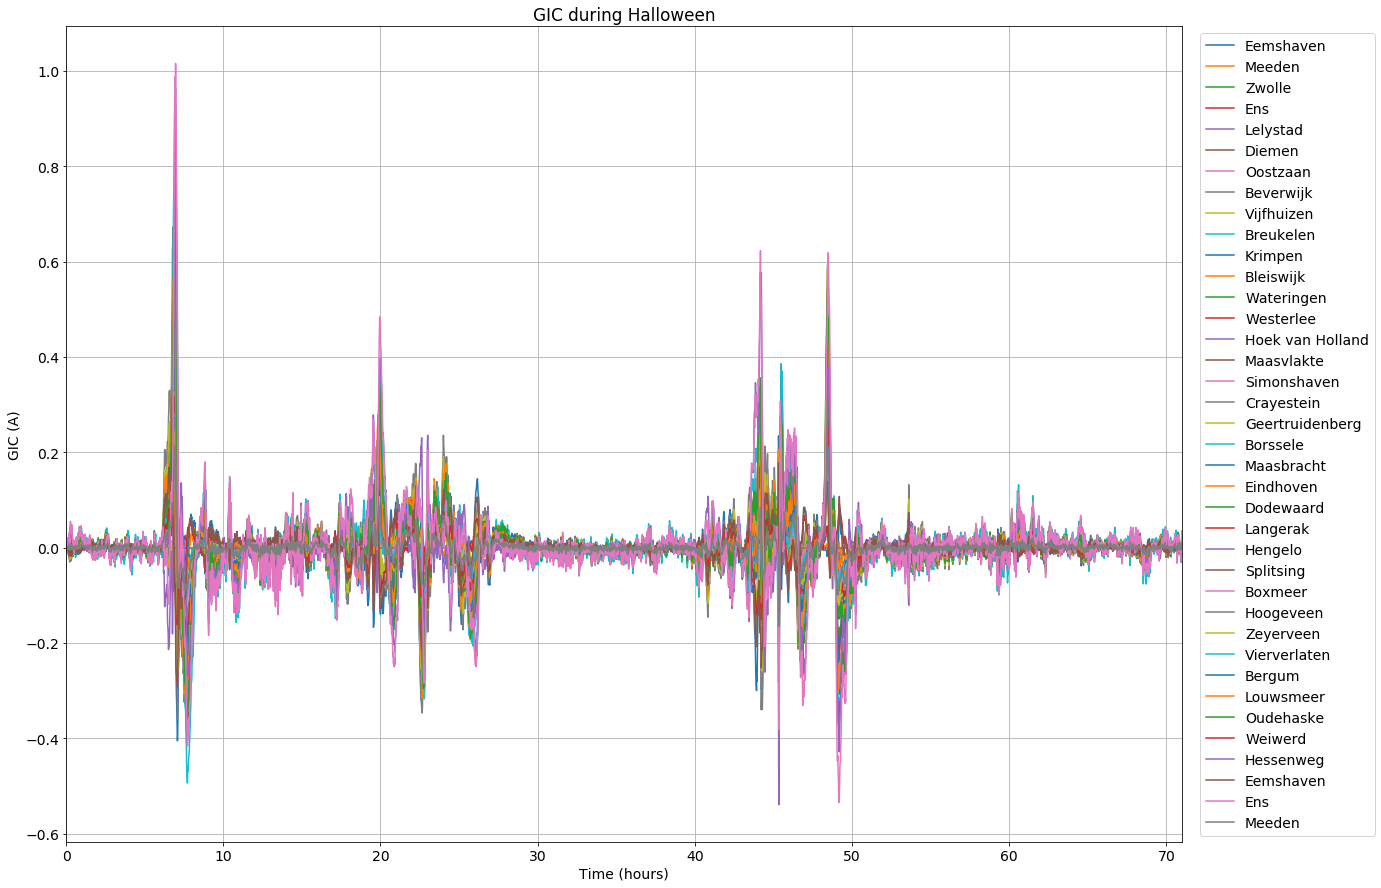

In [6]:
import os
import logging
import numpy as np
A=np.arange(3,21)
B=np.arange(46,57,1)
stationlist=np.hstack([0,1,A,28,29,32,33,35,43,44,B])
# list_of_stations=['bfe','wng','esk','ups','ler','nur','sod','abk','hrn']
logging.basicConfig(filename='/nobackup/users/out/Magnetic_field/Halloween/logbook.log', level=logging.INFO, format='%(asctime)s %(message)s')
Halloween=GIC('/usr/people/out/Documents/new_380+220kV_extended','/usr/people/out/Documents/Magnetic_field/magnetic_data','/nobackup/users/out/Magnetic_field','Halloween')

# Halloween.BtoE(7)
Halloween.calculate_GIC(150,False)
Halloween.plot_GIC(stationlist)
# os.system(f'mv {pad}/electric_field_east {pad}/model10_filt/electric_field_east')
# os.system(f'mv {pad}/electric_field_north {pad}/model10_filt/electric_field_north')
# os.system(f'mv {pad}/GIC {pad}/model10_filt/GIC')
# os.system(f'mv {pad}/GIC_allstations.png {pad}/model10_filt/GIC_allstations.png')
# Halloween.make_video(f'{Halloween.respath}/{Halloween.date}/GIC/GIC_at_',f'GIC_at_{Halloween.date}')
# Halloween.plot_magnetic()

In [4]:
import os
import numpy as np
pad='/nobackup/users/out/Magnetic_field/new_Halloween'
# os.system(f'mv {pad}/GIC {pad}/topology_2/GIC')
# os.system(f'mv {pad}/GIC_allstations.png {pad}/topology_2/GIC_allstations.png')
Halloween=GIC('/usr/people/out/Documents/topology_3','/usr/people/out/Documents/Magnetic_field/magnetic_data','/nobackup/users/out/Magnetic_field','new_Halloween')
# Halloween.calculate_GIC(150,False)
stationlist=np.arange(4)
Halloween.plot_GIC(stationlist)
os.system(f'mv {pad}/GIC {pad}/topology_3/GIC')
os.system(f'mv {pad}/GIC_allstations.png {pad}/topology_3/GIC_allstations.png')
Halloween=GIC('/usr/people/out/Documents/topology_4','/usr/people/out/Documents/Magnetic_field/magnetic_data','/nobackup/users/out/Magnetic_field','new_Halloween')
Halloween.calculate_GIC(150,False)
stationlist=np.arange(8)
Halloween.plot_GIC(stationlist)
os.system(f'mv {pad}/GIC {pad}/topology_4/GIC')
os.system(f'mv {pad}/GIC_allstations.png {pad}/topology_4/GIC_allstations.png')

New data is added now!
Script has been completed!


0

In [53]:
import numpy as np
import pandas as pd
DourbesX=np.zeros(3*1440)
DourbesY=np.zeros(3*1440)
nobackup='/nobackup/users/out/Magnetic_field/NO_Dourbes/interpolation'
for item in range(3*1440):
    A=pd.read_csv(f'{nobackup}/minute_{str(item).zfill(4)}.csv', delimiter=' ', header=None)
    DourbesX[item]=A.iloc[0,2]
    B=pd.read_csv(f'{nobackup}/minute_{str(item).zfill(4)}.csv.Y', delimiter=' ', header=None)
    DourbesY[item]=B.iloc[0,2]
DourbesXS2=DourbesX
DourbesYS2=DourbesY

In [55]:
import pandas
import numpy as np
Dourbesorg=np.zeros((3*1440,2))
A=pd.read_csv('/nobackup/users/out/Magnetic_field/Dourbes/allresults.csv', delimiter=';')
Dourbesorg=A.iloc[:,0:2].to_numpy()

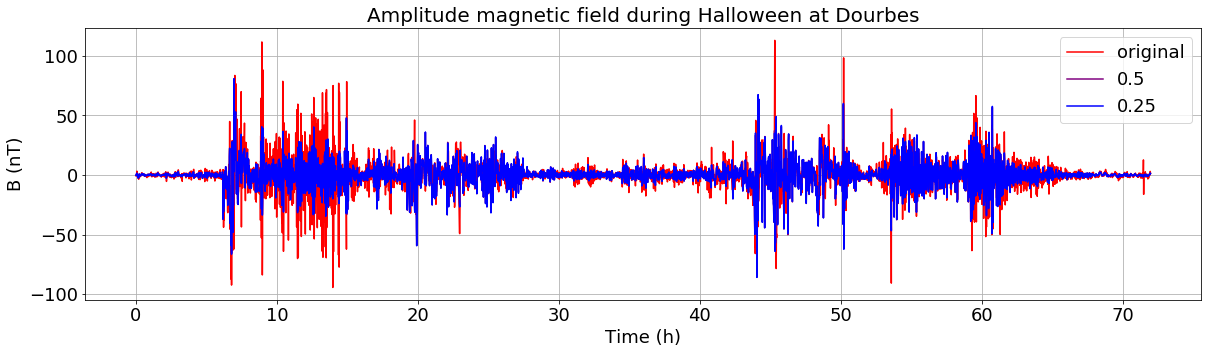

In [184]:
import matplotlib.pyplot as plt
timevector=np.linspace(0,72,1440*3)

fig=plt.figure(figsize=(20,5))
ax1=fig.add_subplot()
# ax2=fig.add_subplot(222)
# ax3=fig.add_subplot(223)
# ax4=fig.add_subplot(224)
ax1.set_title('Amplitude magnetic field during Halloween at Dourbes', fontsize=20)
# ax2.set_title('Y-component')
# ax3.set_title('X-component shifted')
# ax4.set_title('Y-component shifted')
plt.rcParams.update({'font.size': 18})
ax1.plot(timevector[:4319],abs(np.sqrt(Dourbesorg[:,0]**2+Dourbesorg[:,1]**2))[:4319]-abs(np.sqrt(Dourbesorg[:,0]**2+Dourbesorg[:,1]**2))[1:],color='red',label='original')
# ax1.plot(timevector[:4319],abs(np.sqrt(DourbesX2**2+DourbesY2**2))[:4319]-abs(np.sqrt(DourbesX2**2+DourbesY2**2))[1:],color='black',label='2')
# ax1.plot(timevector[:4319],abs(np.sqrt(DourbesX1**2+DourbesY1**2))[:4319]-abs(np.sqrt(DourbesX1**2+DourbesY1**2))[1:],color='green',label='1')
ax1.plot(timevector[:4319],abs(np.sqrt(DourbesX05**2+DourbesY05**2))[:4319]-abs(np.sqrt(DourbesX05**2+DourbesY05**2))[1:],color='purple',label='0.5')
ax1.plot(timevector[:4319],abs(np.sqrt(DourbesX025**2+DourbesY025**2))[:4319]-abs(np.sqrt(DourbesX025**2+DourbesY025**2))[1:],color='blue',label='0.25')
# ax1.set_ylim(0,1000)
# ax1.set_xlim(0,71)
# ax1.plot(timevector[:4319],abs(np.sqrt(Dourbesorg[:,0]**2+Dourbesorg[:,1]**2))[:4319]-abs(np.sqrt(Dourbesorg[:,0]**2+Dourbesorg[:,1]**2))[1:],color='red',label='original')
# ax2.plot(timevector,DourbesX05,color='purple',label='0.5')
# ax2.plot(timevector,Dourbesorg[:,0],color='red',label='original')
# ax2.plot(timevector,DourbesY2,color='black')
# ax2.plot(timevector,DourbesY1,color='green')
# ax2.plot(timevector,DourbesY05,color='purple')
# ax2.plot(timevector,DourbesY025,color='blue')
# ax2.plot(timevector,Dourbesorg[:,1],color='red')
# ax3.plot(timevector,DourbesXS2,color='black')
# ax3.plot(timevector,DourbesXS1,color='green')
# ax3.plot(timevector,DourbesXS05,color='purple')
# ax3.plot(timevector,DourbesXS025,color='blue')
# ax3.plot(timevector,Dourbesorg[:,0],color='red')
# ax4.plot(timevector,DourbesYS2,color='black')
# ax4.plot(timevector,DourbesYS1,color='green')
# ax4.plot(timevector,DourbesYS05,color='purple')
# ax4.plot(timevector,DourbesYS025,color='blue')
# ax4.plot(timevector,Dourbesorg[:,1],color='red')
ax1.grid()
ax1.set_ylabel('B (nT)', fontsize=18)
ax1.set_xlabel('Time (h)', fontsize=18)
ax1.legend()
plt.show()
# plt.savefig(f'/nobackup/users/out/Magnetic_field/Dourbes/Error.png')

In [182]:
np.sum(abs(np.subtract((Dourbesorg[:4319,0]-Dourbesorg[1:,0]),DourbesX2[:4319]-DourbesX2[1:])))/(1440*3-1)

7.287881138698101

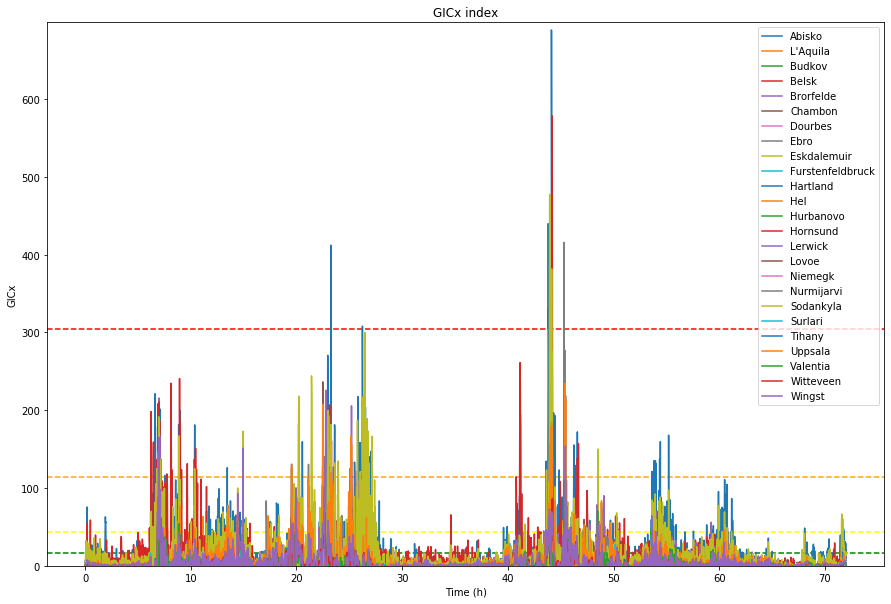

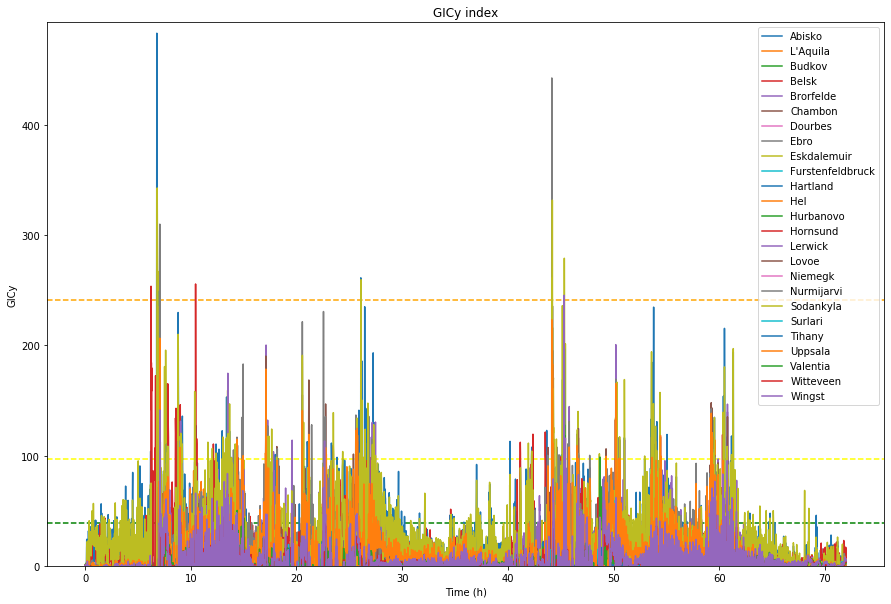

In [30]:
index=GIC('/usr/people/out/Documents/380+220kV_extended','/usr/people/out/Documents/Magnetic_field/magnetic_data','/nobackup/users/out/Magnetic_field','Tozzi_merged')
index.GIC_index(1440,3,True,True)

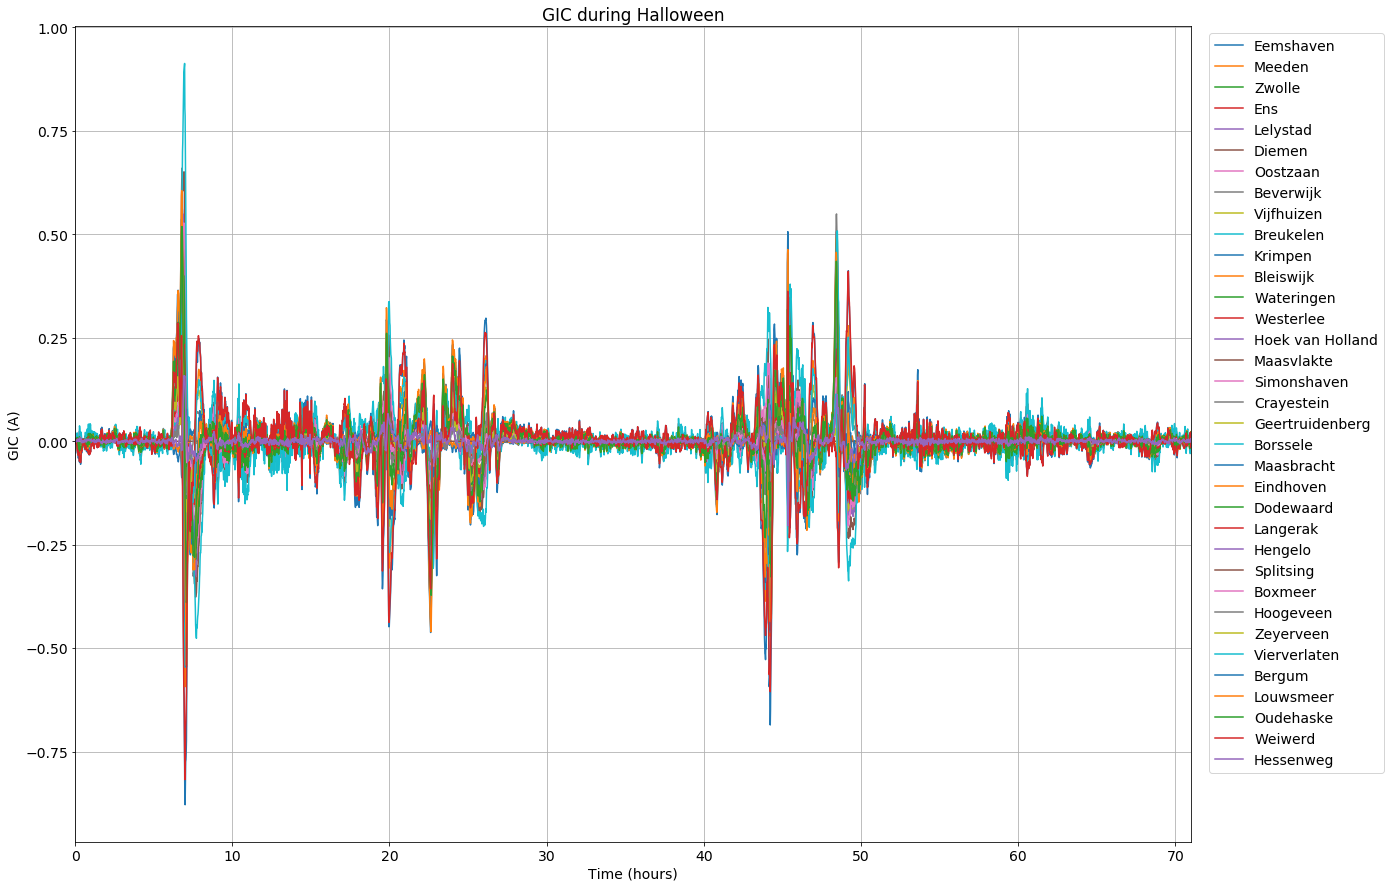

In [34]:
Halloween=GIC('/usr/people/out/Documents/380+220kV_extended','/usr/people/out/Documents/Magnetic_field/magnetic_data','/nobackup/users/out/Magnetic_field','Halloween')

Halloween.plot_GIC()

In [ ]:
import os
os.system('shutdown now')